# Proton Beam Curve Visualisation

#### Introduction:

In this notebook we will showcase the plots of many Proton Beam Curves (PBCs) and cumulative curve made from $n$ Proton Beam Curves to visualise what is know as a Spread out Bragg Peak (SOBP). Given initial energy, $E_{0}$ (written as 'eZero' in the code below), of the PBC, we shall show plots of Dose per Fluence against diplacement and build upon this to more interesting topics such as optimisation of combinations for specific SOBPs and later touch on Uncertainty and further demonstrate with more plots. Throughou the notebook there are interactive cells to show a variety of functions in use.


## Required Imports

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import scipy as sp
import scipy.special.cython_special 
import math as math
import pandas as pd
import itertools as it

from scipy.misc import derivative as dv #unsurprisingly is the derivative function 
from scipy import integrate
from scipy.optimize import minimize
from scipy.optimize import lsq_linear

import sympy as sym

import numpy.ma as ma #this was for the joint curves but not implemented anymore 

import statistics as stat #used for shorthand standard deviation and mean calculation (yes im that lazy to calculate mean)
plt.style.use('default')

#### Defining the unchanging parameters.
All of the subseuqent parameters below are taken from "An analytical approximation of the Bragg curve for therapeutic proton beams", under the assumption that the medium is water.

In [3]:
#Primary stage Parameters - not affected by Beam Initial Energy
p = 1.77
alpha = 0.0022
beta = 0.012
gamma = 0.6
epsilon = 0.0 #ranges 0.0 to 0.2
e_2 = 997 # density of the medium 
sd = 0.01

##### Functions to Calculate Parameters for the Curve 

Firsty we need to calculate the displacement over which the our PBC covers, and the equation for the individual PBC.

The PBC takes the form ... {Enter equation here}

In [4]:
def CalculateXAxis(eZero): # Send in a single eZero Value, returns the x-axis to scale

    rZeroMax = alpha*(eZero**p) #energy
    z = np.arange(0,rZeroMax*1.1,0.1) #multiply by 1.1 to allow the plot to have greater range (visually nicer).
    
    return(z)

def CalculateXAxisList(eZeroList): # Send in a multiple eZero Values in List/tuple... returns the x-axis to scale 

    eZeroMax = int(max(eZeroList)) # Seleceting the greatest eZero to allow for all curves to be shown in plot 
    rZeroMax = alpha*((eZeroMax**p))
    z = np.arange(0,rZeroMax*1.1,0.1) #multiply by 1.1 to allow the plot to have greater range (visually nicer).
    
    return(z)

def CalculateSecondary(eZero,z): 
    # Send in eZero and the specific x axis, returns all calculated values and dict for df visualisation later
        
    #Secondary Stage Parameters
    rZero = alpha*(pow(eZero,p))
    sigE0 = 0.01*eZero
    sigMono = beta*(rZero**0.935)
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -z)/sigma
    phiZero = 1 + beta*(rZero)
    
    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))
    
    #Appending few data to dictionary for DataFrame use 
    secondaryData = {"eZero":eZero, "rZero": rZero,"sigma":sigma,
                     "phiZero":phiZero}
    
    return(secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)


def CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2): 
    # Send in Values calculated in CalculateSecondary(...), returns the curve function (set of discrete points).
    
    curve =  (phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
    1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
    ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2)

    return(curve)

##### Functions to Calculate the Curve (using the above parameter functions)

To save time using the above functions, I intend on creating two more functions that depending on the amount of $E_0$ that need to be evaluated and hence the amount of PBCs, 

In [5]:
def CalculateSingularPBC(eZero,df): #Send in MeV, returns curve and Dataframe with information about the curve.
    
    #Predefined Variables
    z = CalculateXAxis(eZero)
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)

def CalculateMultiplePBC(eZero,z,df): #Send in MeV, returns curve values.
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)

def CalculateSingularPBCNoDF(eZero): #Send in MeV, returns curve and Dataframe with information about the curve.
    
    #Predefined Variables
    z = CalculateXAxis(eZero)
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    
    return(curve)

def CalculateMultiplePBCNoDF(eZero,z): #Send in MeV, returns curve values.
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    return(curve)

#### Plotting Functions:

As you would expect, this next cell contains all the plotting cells I require.
I have decided to make three functions with slightly different uses, these are:

$i)$ A Singular Proton Beam Curve

$ii)$ A Cumulative Proton Beam Curve from a range of $E_0$ values - generally for SOBP analysis. 

$iii)$ A Combination of Cumulative Proton Beam Curves and Individual Proton Beam Curves from a range of $E_0$ values.


In [6]:
def PlotCurve(eZero): # Send in ONE eZero, Calculates individual PBC and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curve, CurveData = CalculateSingularPBC(eZero,CurveData)
    z = CalculateXAxis(eZero)
    plt.plot(z,curve, label = (str(eZero)+ "MeV"))
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Individual Bragg Curve Plot")
    
    plt.legend(loc='best')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
def PlotCumulativeCurve(eZero): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBC(i,z, CurveData)
        curveList.append(curve)
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative Proton Beam Curve Plot")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
    
def PlotCumulativeCurveAndInd(eZero): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBC(i,z,CurveData)
        curveList.append(curve)
        plt.plot(z,curve, label = (str(i)+ "MeV"))
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative and Individual Proton Beam Curve Plot")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    

##### Showcase of Plotting Functions:

   eZero      rZero     sigma   phiZero
0  120.0  10.533519  0.215698  1.126402
1  130.0  12.136750  0.247954  1.145641


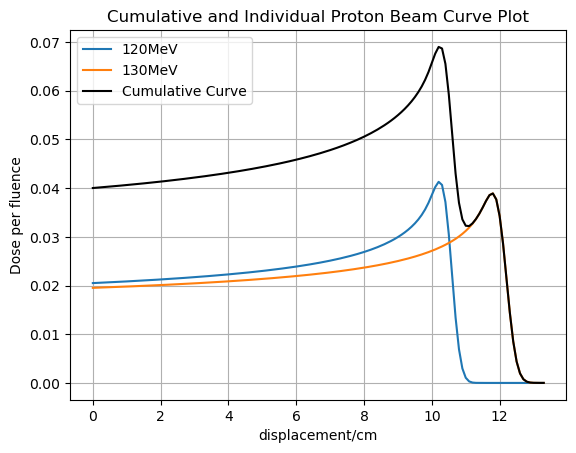

In [7]:

eZeroList = [120,130]
#for i in eZeroList:
#    PlotCurve(i)
#plt.show()

#PlotCumulativeCurve(eZeroList)
#plt.show()

PlotCumulativeCurveAndInd(eZeroList)
plt.show()

#### Interactive Plotting Function:

In [8]:
def InteractivePlot():

    text = ""
    while text != 4:
        eZeroList = []
    
        text = int(input("Menu. Choose Menu item: \n 1: Plot Individual PBC(s)"
             +"\n 2: Plot Only Cumulative Curve \n 3: Plot Cumulative Curve and Individual PBC(s)"
             +"\n 4: Quit \n"))
    
        if text ==1 or text ==2 or text ==3:
            amountOfCurves = int(input("Enter amount of Curves: "))
            for i in range(amountOfCurves):
                eZero = int(input("Enter eZero number "+ str(i+1)+ ": "))
                if text ==1:
                    PlotCurve(eZero)
                eZeroList.append(eZero)
            plt.show()
            
            if text ==2:
                PlotCumulativeCurve(eZeroList)
                plt.show()
            elif text ==3:
                PlotCumulativeCurveAndInd(eZeroList)
                plt.show()

As mentioned in the Intorduction, this is the first of a few interactive cells. Note: the range of $E_0$ values must be in the range of 50-200 MeV to accurately by visualised by any of these functions and the following plots.


In [9]:
#InteractivePlot()


## Target Tumor Range.
Ideally we want to 'aim' our cumulative PBC at a desired range of which a tumor would be located. 
This is an import part of identifying which SOBP should be used and which should be rejected as we will see later.


We now need the function to plot this Tumor range, hence the following cell.
##### Functions To Plot Target Range:

In [10]:
def PlotSimpleBox(): 
    #takes no aguments, plots dashed lines of tumour range and doseage required
    plt.hlines(y=0.1,xmin = 12,xmax = 15, color='r', linestyles='dashed')
    plt.vlines(x=12,ymin = 0,ymax = 0.1, color='r', linestyles='dashed')
    plt.vlines(x=15,ymin = 0,ymax = 0.1, color='r', linestyles='dashed', label = "Target Range")

def PlotCustomBox(upper,lower,dose):
    # takes three aguments. Upper and lower dispalcement values and target doseage value.
    # plots dashed lines of tumour range and doseage required
    plt.hlines(y=dose,xmin = lower,xmax = upper, color='r', linestyles='dashed')
    plt.vlines(x=lower,ymin = 0,ymax = dose, color='r', linestyles='dashed')
    plt.vlines(x=upper,ymin = 0,ymax = dose, color='r', linestyles='dashed', label = "Target Dose")
    

###### Showcase of SimpleBox Function:

   eZero      rZero     sigma   phiZero
0  130.0  12.136750  0.247954  1.145641
1  140.0  13.837872  0.282111  1.166054
2  150.0  15.635228  0.318135  1.187623
3  160.0  17.527301  0.355993  1.210328


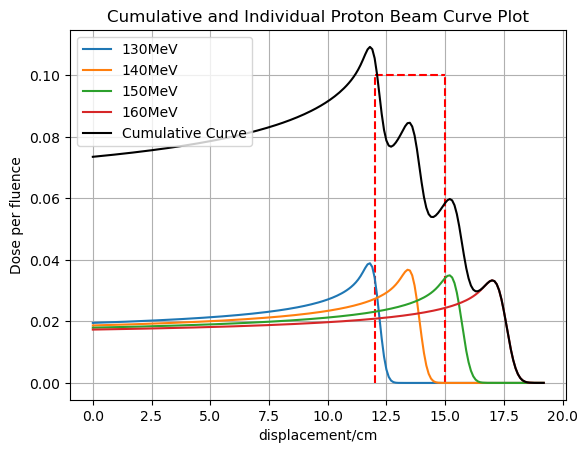

In [11]:
eZeroList = [130,140,150,160]

PlotCumulativeCurveAndInd(eZeroList)
PlotSimpleBox()

plt.show()

## Storing Data
As we can see, we now can plot many curves of many kinds of initial energy values. 
If we are to optimise this, we would likely find it useful to retrieve information from each curve such as the highest Peak per Fluence value of the curve and what displacement value this occurs at. 
Hence, moving forward I shall create a DataFrame that will contain all the curves peak dose (peakDose) and displacement of the peak dose (rMax) of energy values 50 to 200, to aid futher optimisation. 

We will first need a function that can calculate the Peak Dose and find the Displacment of such value...

In [12]:
def CalculatePeakDoseZValue(curve,z): 
    # takes curve, as calculated from CalculateCurve() function, and range of which to plot the curve as arguments
    # returns Peak Dose and displacement of point of Peak Dose
    
    rMax = 0
    peakDose = max(curve)
    
    for i in range(len(z)):
            if curve[i] == peakDose:
                rMax = i/10
                return(peakDose,rMax)
    

The next cell finds the Peak Dose and Displacement of Peak Dose from all curves of energy Values from 50 to 200MeV, and storing data in relevant DataFrame:

   eZero  peakDose  rMax
0   50.0  0.074870   2.2
1   51.0  0.073825   2.2
2   52.0  0.075793   2.3
3   53.0  0.076328   2.4
4   54.0  0.074695   2.5


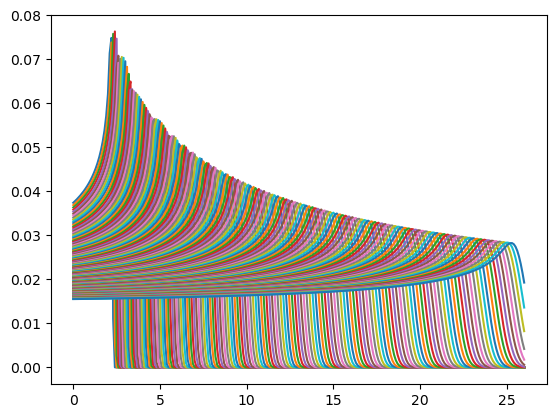

In [13]:
energyData = pd.DataFrame()
    
z = np.arange(0,alpha*(200**p),0.1)

for i in range(50,201): #lets just say 200 as 200 MeV is the max aproxiamted 
    eZero = i
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    plt.plot(z,curve)
    peakDose,rMax = CalculatePeakDoseZValue(curve,z)
    datum = {"eZero": i, "peakDose":peakDose,"rMax": rMax}
    beamData = pd.Series(data = datum,index = datum.keys())
    energyData = pd.concat([energyData, beamData.to_frame().T], ignore_index=True)
print(energyData.head())

In [14]:
energyData.to_csv("energyData.csv")

## Simple Optimisation 
##### Introduction
Choosing the best SOBP is an ideal outcome from this model, however many questions come along with it. 
Care must be taken to minimise over doseage of radiation over the required range and otherwise.
It can be seen that due to every curve within the range 50 to 200 MeV having very similar dosage at the first Data Point avaliable, there must be a maximum amount of curves usable until the required doseage is the initial value of the SOBP curve and hence can be taken as an upper bound for amount of curves necessary to solve a system. 

##### Plot of PBC of Energy Values from 50 to 200 MeV  initial dosage:

The cell below plots the initial value of each curve generated from the energy values of 50 to 200 MeV.
Clearly there is a trend such that, as the energy value of the PBC increases the initial Dose per Fluence decreses, i.e Energy of beam is inversly Propotional to initial Dose per Fluence. 

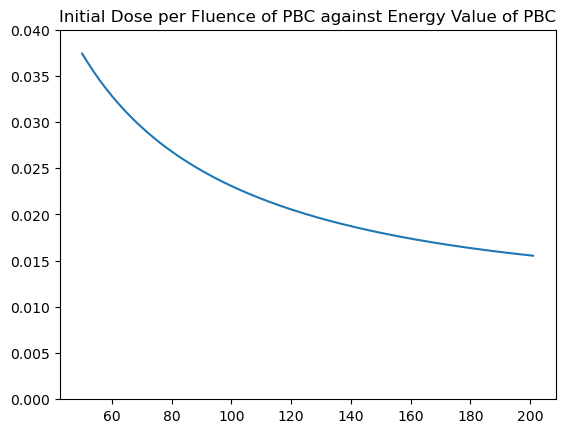

In [15]:
initialPointList = []
for i in energyData.eZero:
    
    df = pd.DataFrame()
    curve, df = CalculateSingularPBC(i,df)
    initialPoint = curve[0]
    initialPointList.append(initialPoint)
    
plt.plot(np.linspace(50,201,151),initialPointList)
plt.ylim([0,0.04])
plt.title("Initial Dose per Fluence of PBC against Energy Value of PBC")
plt.show()

##### Explanation:
So what does this mean? 

This trend imples that to work out an upper bound of amount of PBC to make up a SOBP curve to achieve target dose, we should divide the target dose by the initial energy value of the **highest** availiable energy value PBC. 

##### Example of finding the maximum amount of curves for the SimpleBox() 
First we need a fucntion to do what was explained above in the Explanation:

In [16]:
def CalculateMaxCurves(dose, upper, energyData):
    df = energyData[(energyData["rMax"] <= upper)]
    eZero = max(df.eZero)
    curve,df = CalculateSingularPBC(eZero,df)
    eInitial = curve[0]
    
    maxCurves = int((dose // eInitial)+1)
    
    return(maxCurves)

As we are using the SimpleBox() example we should send in the 'dose' and 'upper' value associated with SimpleBox(). 

Dose = 0.1

Upper = 15

In [17]:
dose = 0.1
upper = 15

mxNo = CalculateMaxCurves(dose,upper,energyData)
print("amount of curves should be upper bounded by "+ str(mxNo))

amount of curves should be upper bounded by 6


This now provides us with a reasonable place to start.
###### Graphical representation of Upper bound of 'number of curves':

As the below cell shows, the minimum doseage prior the peak doseage is higher than that of the expeceted maximum target dosage.

Let $r$ be the number of curves chosen, and let $m$ be the upper bound calculated by the function CalculateMaxCurves.

Hence for any number of curves greater than or equal to the upper bound, $r \ge m$, any combination of $r$ energy values will either:

$i)$ Cover the full target range but over dose target range and non target range (provided that the $E_0$'s selected are associated to having the peak at the upper limit of the target area). An example of this is shown in the cell below.

$ii)$ Cover less than the required target range and over dose the target and non target range that is hit even more heavily the option $i)$. This is due to lower $E_0$ PBC or Cumulative PBCs having higher initial Dose per Fluence value as seen in the plot "Initial Dose per Fluence of PBC against Energy Value of PBC.
##### Graphical Representation where r = m:

   eZero      rZero     sigma   phiZero
0  149.0  15.451206  0.314449  1.185414
1  149.0  15.451206  0.314449  1.185414
2  149.0  15.451206  0.314449  1.185414
3  149.0  15.451206  0.314449  1.185414
4  149.0  15.451206  0.314449  1.185414


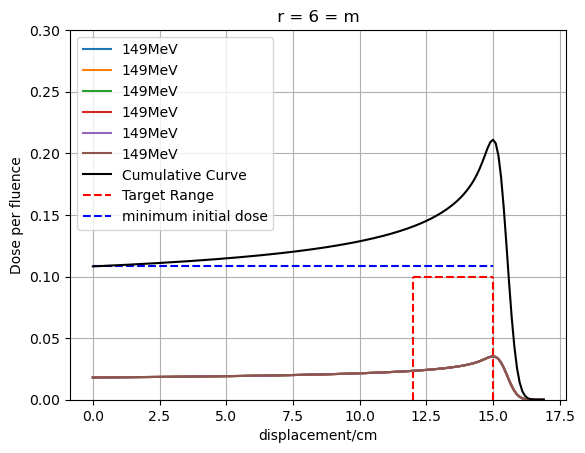

In [18]:
r = 6

x = energyData[energyData.rMax == upper]
eVals = []
for i in range(r):
    eVals.append(int(x.eZero))

PlotCumulativeCurveAndInd(eVals)
PlotSimpleBox()
plt.ylim([0,0.3])

curve,df = CalculateSingularPBC(eVals[0],df)
initialEnergy = curve[0]

plt.hlines(y=initialEnergy*6,xmin = 0,xmax = 15, color='b', linestyles='dashed', label = "minimum initial dose")
plt.legend(loc = "upper left")
plt.title(" r = 6 = m ")
plt.show()

##### Graphical Representation where r > m:

   eZero      rZero     sigma   phiZero
0  149.0  15.451206  0.314449  1.185414
1  149.0  15.451206  0.314449  1.185414
2  149.0  15.451206  0.314449  1.185414
3  149.0  15.451206  0.314449  1.185414
4  149.0  15.451206  0.314449  1.185414


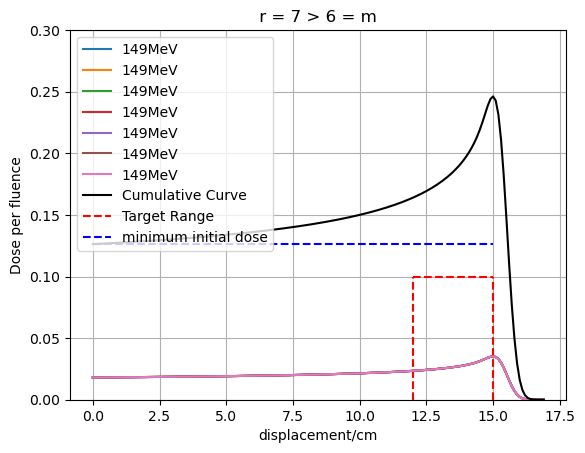

In [19]:
r = 7
x = energyData[energyData.rMax == upper]
eVals = []
for i in range(r):
    eVals.append(int(x.eZero))

PlotCumulativeCurveAndInd(eVals)
PlotSimpleBox()
plt.ylim([0,0.3])

curve,df = CalculateSingularPBC(eVals[0],df)
initialEnergy = curve[0]

plt.hlines(y=initialEnergy*7,xmin = 0,xmax = 15, color='b', linestyles='dashed', label = "minimum initial dose")
plt.legend(loc = "upper left")
plt.title(" r = 7 > 6 = m ")
plt.show()



##### Graphical Representation where r < m:

   eZero      rZero     sigma   phiZero
0  149.0  15.451206  0.314449  1.185414
1  149.0  15.451206  0.314449  1.185414
2  149.0  15.451206  0.314449  1.185414
3  149.0  15.451206  0.314449  1.185414


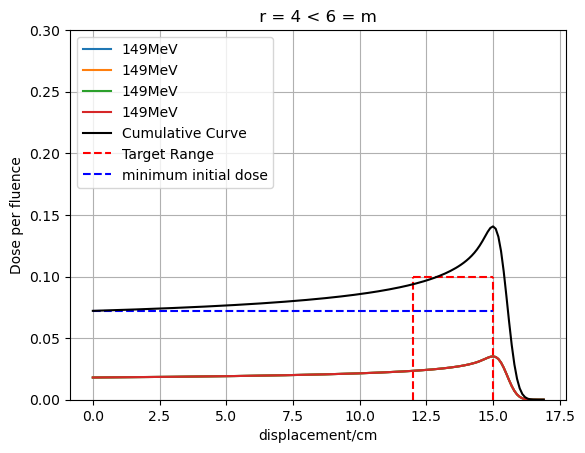

In [20]:
r = 4

x = energyData[energyData.rMax == upper]
eVals = []
for i in range(r):
    eVals.append(int(x.eZero))

PlotCumulativeCurveAndInd(eVals)
PlotSimpleBox()
plt.ylim([0,0.3])

curve,df = CalculateSingularPBC(eVals[0],df)
initialEnergy = curve[0]

plt.hlines(y=initialEnergy*4,xmin = 0,xmax = 15, color='b', linestyles='dashed', label = "minimum initial dose")
plt.legend(loc = "upper left")
plt.title(" r = 4 < 6 = m ")
plt.show()



##### Combinations:

Provided that the amount of curves, $r$, is less than our calculated upper bound number of curves, $m$, we can begin to think about which combination of individual proton beam curves may produce the 'best' SOBP over our desired range. Note, our combinaions of the individual proton beam curve selection follows a 'Sampleing with replacement' and 'unordered' aproach implying that the total number of combinations follows the formula: $\frac{(n - 1 + r)!}{(n - 1)!(r)!}$ . 

Where $n$ = number of curves to choose from, and $r$ = amount of curves. This also consequently means that the order of growth and hence Big O notation is $O(n!)$

##### Defining 'Best':
Our ideal curve would have minimum radiation outside all areas of the target range and exactly our required doseages in the target area. Note, it is better to slightly over radiate than under radiate in our target range. 
Put simpler, we need our SOBP 'percentage above or equal to the doseage requirement over require range' to be as great as possible.
Furthermore, we need our 'distance from required doseage and the SOPB over required range' to be as small as possible.
This is to eliminate over radation or get as close to hitting required radiation value as possible.

##### Utilising energyValues DataFrame:
For simple problems that can be solved heuristicly by non machine learning (ML) implementation, such as our simple box scenario, we may notice that all the individual PBC peaks must lie within the target range. 
This is very useful. It allows us to create a new smaller dataframe from our energyValues DataFrame that has smallest rMax value greater than or equal to the lower bound of the target dose raneg, and rMax greatest value equal to or less than upper bound of the target dose range.

###### Heres a function that trims the energyData DataFrame to do exactly that:


In [21]:
def RestrictDfRanges(df, lower,upper):
    # takes energyData DataFrame, lower bound and upper bound of the target range as arguments.
    # Returns a new trimmed DataFrame restricted to the rMax values greaters than or equal to lower bound
    # and less than or equal to upper bound.

    df2 = energyData[(energyData["rMax"] >= lower)]
    df2 = df2[(df2["rMax"] <= upper)]

    return(df2)

##### Optimisation process:
Once our new DataFrame of energyValues has been returned, we can work out how many combinations of PBCs there are. For each individual SOBP we then review every datapoint of the SOBP in the target range and caluclate the percentage of the whole SOBP (within the target range) that is above the required doseage .Similarly, we then caluclate the average distance of the whole SOBP (within the target range) from the required doseage. Finally we can append this to a new dataframe and sort accordinly to the best curve first. 

Once again, we need some fucntions. 

###### Function to calculate important information from the curve:

In [22]:
def CalculateInfo(dose,lower, upper, SOBP):
    # Takes targetDose, lower bound and upper bound of target range and the SOBP curve as arguments.
    # Returns Standard Deviation, Average Distance of curve to target dose, Percentage of the SOBP Above Dose Line.
    
    lower = int(lower)
    upper = int(upper)
    avgDistList = []
    z2 = np.arange(lower,upper,0.1)
    regionOfCurve = SOBP[lower*10:upper*10] #times 10 as z has 0.1 increments 
    
    stdDev = np.std(regionOfCurve)
    
    #Calculating the average distance away from the curve in the y axis and percentageAboveDose 
    counter = 0
    
    for i in regionOfCurve:
        avgDist = dose-i
        if avgDist<=0:
            counter = counter +1
            avgDist = abs(avgDist)
        avgDistList.append(avgDist)
    avgDist = sum(avgDistList)/len(avgDistList)
    
    percentageAboveDose = counter/len(SOBP[lower*10:upper*10])
    
    return(stdDev, avgDist, percentageAboveDose)
    

Combining the funcitons mentioned, we can make a function that rudimentally optimises for curves up to a certain amount.

##### Optimising Fucntion:

In [23]:
def Optimiser(): 
    # Takes no arguments, returns DataFrame of SOBP curves in rank order.
    
    option = int(input("Choose Simple Box? \n 1:yes \n 0:no \n"))

    if option == 0:
        upper = round(float(input( "upper Bound Value (float): ")),2)
        lower = round(float(input( "lower Bound Value (float): ")),2)
        dose = round(float(input( "Dose Value (float): ")),2)
        PlotCustomBox(upper,lower,dose)
    
    elif option == 1:
        PlotSimpleBox()
        upper = 15
        lower = 12
        dose = 0.1 
        
    mxNo = CalculateMaxCurves(dose, upper, energyData) #max # of curves i should use to get the SOBP else dosage too high
    print("Your given doseage has upper bound number of curves needed as " + str(mxNo))
    r = int(input("Number of curves to use (maximum is 5)? :")) # change to the optimised version later
    
    #trim the range of energyValues()
    df = RestrictDfRanges(energyData,lower,upper)
    
    #defining variables:
    cdf = pd.DataFrame() #dataFrame to contain the energy Values and stats about the SOBP 
    
    eZeroOne = None
    eZeroTwo = None
    eZeroThree = None
    eZeroFour = None
    eZeroFive = None
    curveList = []
    eZeroList = [] # list used to hold all eZero values
    
    #Combinations
    n = len(df.eZero) # the amount of eZero values to iterate through 
    print(" r = "+str(r)+ "\n n = "+ str(n))
    
   
    for i in range(n-1):
        eZeroList.append(df.eZero.iloc[i])
    # eZeroList now hold all eZero values
    
    combList = list(it.combinations_with_replacement(eZeroList,r))
    #comb list now holds all the combinations of values in eZeroList.
    
    print("Total amount of combinations = " + str(len(combList))) 

    for combo in combList:
        curveList =[] 
        z = CalculateXAxisList(combo)
            
        for eZero in combo:
            curve,df = CalculateMultiplePBC(eZero,z, df) # Calculate individual PBC
            curveList.append(curve) 

        sobp = sum(curveList) # Calculate SOBP
            
        stdDev, avgDist, percentageAboveDose= CalculateInfo(dose,lower, upper,sobp) # Calculate the info for the df later

        #append data to cdf
        if r == 2:
            eZeroOne = combo[0];eZeroTwo = combo[1]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 3:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 4: 
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r ==5:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];eZeroFive = combo[4]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                     "eZeroFive": eZeroFive,"standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,
                     "percentageAboveDoseLine":percentageAboveDose}

        beamData = pd.Series(data = datum,index = datum.keys())
        cdf = pd.concat([cdf, beamData.to_frame().T], ignore_index=True)


    #sort the df by percentageAboveDoseLine values
    df2 = cdf.sort_values(by = ['percentageAboveDoseLine','averageDisplacementFromDose'], ascending = [False,True])
    
    for j in range(3): #for the top 3 curves  
        eVals = []          
        for i in range(r): # take the n curves that make the sobp
            eVals.append(df2.iloc[j][i]) #add the eZeros to a list 
        print("BEST CURVE NUMBER "+str(j+1))
        PlotCumulativeCurveAndInd(eVals) #Plot the List 
        PlotCustomBox(upper,lower,dose)
        plt.show()
    return(df2)

In [24]:
#df = Optimiser()
#df.head()

# Uncertainty, Accuracy and Monte Carlo Visualisations

##### Introduction
Now we can visualise SOBP and individual PBCs this allows us to think about visualising uncertainty. In all previous plots we have assumed that the medium the PBC is projected at is water - a constant density. However, experimental data shows when projecting PBC or SOBP curves through a medium that doesnt have constant density, such as general body matter, we get a certain level of uncertainty associated with this. 
We can express this uncertainty in the following manner. 
Let $f(z)$ denote the PBC of some particular Energy Value we can model. Then, $f(z + \phi)$ where $\phi \sim  N(0,\theta)$ for some small $\theta$. Note $\theta$ is the Standard deviation not the Variance. 

#### Uncertainty
{Add Metropolis hastings info here}

For Example, $ z=[0,1...],  \phi \sim N(0 ,\theta ) ,  z + \phi = [0 + \phi, 1+ \phi ...]$

First lets define the function that can simulate $f(z+\phi)$ for some  $\phi \sim  N(0,\theta)$.


##### Curve Function with Unncertainty included:

In [25]:
 def CalculateSecondaryNorm(eZero,z, theta):
    
    phi = np.random.normal(0,theta,1)
    #Secondary Stage Parameters
    rZero = alpha*(eZero**p)
    sigE0 = 0.01*eZero
    sigMono = beta*(rZero**0.935)
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -(z+phi))/sigma
    phiZero = 1 + beta*(rZero)
    
    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))
    
    #Appending few data to dictionary for DataFrame use 
    secondaryData = {"eZero":eZero, "rZero": rZero,"theta":theta,
                     "phi":round(float(phi),2)}
    
    
    
    return(secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z)

As before, we now need to create the function to plot the curve and calculate the curves with the 'theta' argument passed through. The following cells are no different to the previous funcitons with similar names aside from the initial argument and hence the uncertainty in the outcome.

##### Functions to Calculate the Curve with Uncertainty Included (using the above parameter functions)

In [26]:
def CalculateSingularPBCNorm(eZero,df,theta): #Send in MeV, returns curve and Dataframe with information about the curve.
    
    #Predefined Variables
    z = CalculateXAxis(eZero)
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z = CalculateSecondaryNorm(eZero,z,theta)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)

def CalculateMultiplePBCNorm(eZero,z,df,theta): 
    # Send in eZero, rnage of dispalceent Valeus, DataFrame to contain data, and Standard eviation.
    # Returns curve values.
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z = CalculateSecondaryNorm(eZero,z,theta)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)

In [27]:
def PlotCurveNorm(eZero,theta): # Send in ONE eZero, Calculates individual PBC and Plots, returns nothing. 
    
    CurveData = pd.DataFrame()
    curve, CurveData = CalculateSingularPBCNorm(eZero,CurveData,theta)
    z = CalculateXAxis(eZero)
    plt.plot(z,curve, label = (str(eZero)+ "MeV"))
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Individual Proton Beam Curve Plot WITH uncertainty")
    
    plt.legend(loc='best')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
def PlotCumulativeCurveNorm(eZero,theta): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBCNorm(i,z, CurveData,theta)
        curveList.append(curve)
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative Proton Beam Curve Plot WITH uncertainty")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
    
def PlotCumulativeCurveAndIndNorm(eZero,theta): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBCNorm(i,z,CurveData,theta)
        curveList.append(curve)
        plt.plot(z,curve, label = (str(i)+ "MeV"))
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative and Individual Proton Beam Curve Plot WITH uncertainty")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    

##### Showcase of Plotting Functions with Uncertainty.

   eZero      rZero  theta   phi
0  120.0  10.533519    0.5 -0.54
   eZero      rZero  theta   phi
0  120.0  10.533519    0.5 -0.26
   eZero      rZero  theta   phi
0  120.0  10.533519    0.5 -1.18
   eZero      rZero  theta   phi
0  120.0  10.533519    0.5 -0.25
   eZero      rZero  theta   phi
0  120.0  10.533519    0.5  0.05


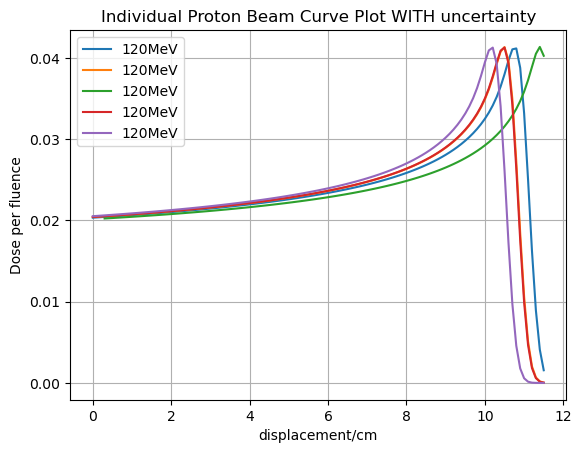

   eZero      rZero  theta   phi
0  120.0  10.533519    0.5 -0.05
1  120.0  10.533519    0.5  0.34
2  120.0  10.533519    0.5  0.08
3  120.0  10.533519    0.5 -0.26
4  120.0  10.533519    0.5  0.06


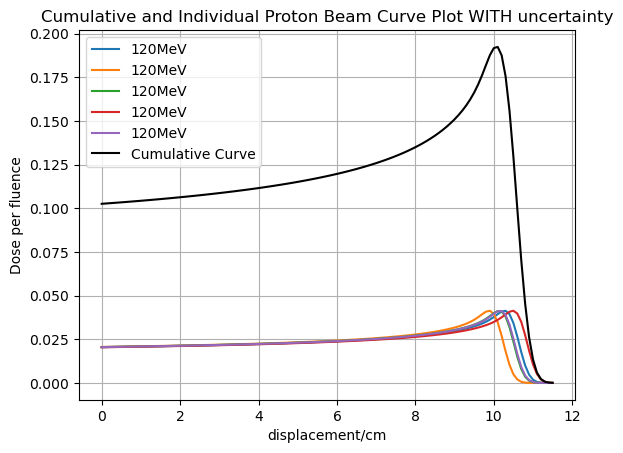

In [28]:
theta = 0.5
eZeroList = [120,120,120,120,120]

for i in eZeroList:
    PlotCurveNorm(i,theta)
plt.show()

PlotCumulativeCurveAndIndNorm(eZeroList,theta)
plt.show()

#### Interactive Plotting Function with Uncertainty:

In [29]:
def InteractivePlotNorm():

    text = ""
    while text != 4:
        eZeroList = []
    
        text = int(input("Menu. Choose Menu item: \n 1: Plot Individual PBC(s) with Uncertainty"
             +"\n 2: Plot Only Cumulative Curve with Uncertainty \n 3: Plot Cumulative Curve and Individual PBC(s) with Uncertainty"
             +"\n 4: Quit \n"))
    
        if text ==1 or text ==2 or text ==3:
            amountOfCurves = int(input("Enter amount of Curves: "))
            theta = float(input("Enter value for Theta: "))
            for i in range(amountOfCurves):
                eZero = int(input("Enter eZero number "+ str(i+1)+ ": "))
                if text ==1:
                    PlotCurveNorm(eZero,theta)
                eZeroList.append(eZero)
            plt.show()
            
            if text ==2:
                PlotCumulativeCurveNorm(eZeroList,theta)
                plt.show()
            elif text ==3:
                PlotCumulativeCurveAndIndNorm(eZeroList,theta)
                plt.show()

In [30]:
#InteractivePlotNorm()

## Visualisations: Monte Carlo Aproach.

As we know the uncertainty variable, $\phi$, and how it is distributed $N(0,\theta)$ we should be able to understand that the distribution of a particular energy value will vary with $N(0,\theta)$ over some range, $x$.
By knowing that $99.7$% of the data of a Normal distribution lies within $3$ standard deviations, hence $3\theta$, eitherside of the mean. We therefore know that the range of which $99.7$% of the data from this distribution will land will be within ErrorBars of our non-Uncertainty included PBC/SOBC Plots.

The same argument can be made for the equivalent $2$ and $1$ standard deviation(s) accuracy value.

|$n$ Standard Devations |Percentage of the Data lying within n Standard Deviation of the Mean|
|---|---|
|1|65|
|2|95|
|3|99.7|

Lets define a few functions to visualise the Uncertainty and Distribution the uncertainty follows.
##### Plotting Visualistions Function:

In [31]:
def PlotVisualisations(eZero,n, theta):
#Predefined Variables
    curveList = []
#Start:

    PlotCurveNorm(eZero,0)

#retrieve all the energies first to work out max range for final plot
    z = CalculateXAxis(eZero)
    for i in range(n): 

    
    #Calculating Data
        secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z = CalculateSecondaryNorm(eZero,z,theta)
        curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        curveList.append(curve)
    
    #plotting
        if i == 1:
            plt.plot(z,curve, color = "pink",alpha = 0.9, label = "Uncertainty Range")
        else:
            plt.plot(z,curve, color = "pink",alpha = 0.02)
#details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Proton Beam Curve with "+str(n)+ " samples of uncertain PBCs")
    plt.grid(True)
    plt.xlim([0,(z[len(z)-1] +theta*3)]) #restricting the area to upper bound it by 3 times the theta 
    plt.legend()
    

The cell below shows the visualisations of 2000 samples of the PBC with particular Energy Value pf 120MeV when sampled with $\theta = 0.1$

   eZero      rZero  theta  phi
0  120.0  10.533519    0.0  0.0


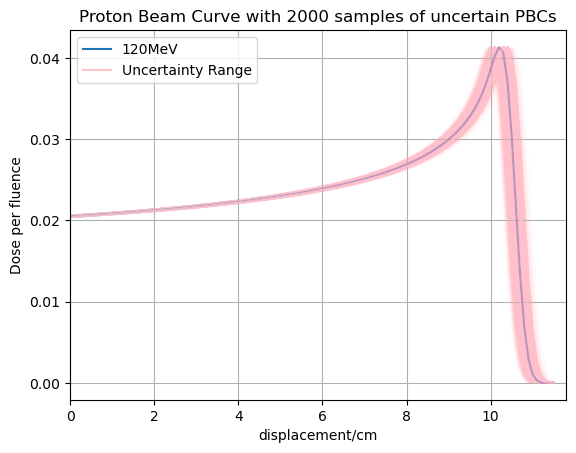

In [32]:
eZero = 120; numerOfCurves = 2000; theta = 0.1;
PlotVisualisations(eZero,numerOfCurves,theta)

##### Interactive Uncertainty Visualisaition Plot:

In [33]:
#theta = float(input("Enter the value for the Standard deviation: "))
#eZero = int(input("Enter the Energy Value: "))
#numberOfVisualisations = int(input("Enter the amount of Visualiations: "))

#PlotVisualisations(eZero,numberOfVisualisations,theta)

#### Visualisations: Error Bars:
Another previously mentioned technique of visualising uncertainty will be with the use of error bars. 
They represent the same information as $\lim{n\to\infty}$ visualisation, however it will be much quicker to compute error bars on a plot rather than a very large amount of visualisations- should we be dealing with many curves this computational complexity only compounds. 

##### Error Bar Uncertainty Function for a singular PBC:

In [34]:
def PlotSingularPBCNormEB(eZero,nStdDev,theta):
    
    #Calculating Data
    z = CalculateXAxis(eZero)
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z);
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    #plotting
        #random colors
    r = round(float(np.random.uniform(0,1,1)),1)
    g = round(float(np.random.uniform(0,1,1)),1)
    b = round(float(np.random.uniform(0,1,1)),1)
    plt.plot(z,curve, label =  (str(eZero)+ "MeV"),color = (r,g,b))
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Proton Beam Curve with Error bars of "+str(nStandardDeviations)+" Standard Deviations ")
    plt.legend(loc = "upper left")
    #error bar
    plt.errorbar(z,curve,xerr = nStandardDeviations*theta, elinewidth = 0.5,color = (r,g,b))
    plt.xlim(0,z[len(z)-1]+(nStandardDeviations*theta))

##### Example of Error Bar Uncertainty Function:

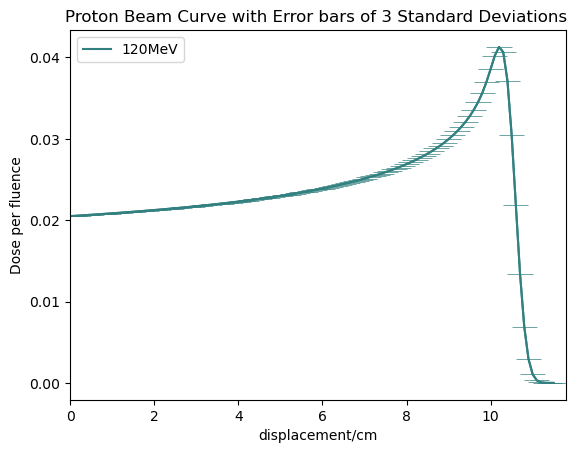

In [35]:
eZero = 120; nStandardDeviations = 3; theta = 0.1;
PlotSingularPBCNormEB(eZero,nStandardDeviations,theta)

Before moving further, it should prove useful to make functions to plot SOBP curves with associated error bars as has been for all previous plotting funcitons. For completness in conjunction with the previous plotting functions I have followed the same techniques as can be seen in the following cell: 

#### Error bar Uncertainty function for SOBP and Multiple PBCs:

In [36]:
def PlotCumulativeCurveNormEB(eZero,nStdDev,theta):
    
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    amountOfCurves = len(eZero)
    #Calculating Data
    z = CalculateXAxisList(eZero)
     
    for i in eZero:
        curve,CurveData = CalculateMultiplePBC(i,z, CurveData)
        curveList.append(curve)
        
    cumulativeCurve = sum(curveList)
    
    #plotting 
    plt.plot(z,cumulativeCurve, color = "k", label = "Cumulative Curve")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("SOBP with Error Bars of "+str(nStandardDeviations)+" Standard Deviations ")
    plt.legend(loc = "upper left")
    
    #error bar
    plt.errorbar(z,cumulativeCurve,xerr = nStandardDeviations*theta*amountOfCurves, color = "k", elinewidth = 0.5)
    plt.xlim(0,z[len(z)-1]+(nStandardDeviations*theta))
    plt.grid(True)
    plt.show()

def PlotCumulativeCurveAndIndNormEB(eZero, nStdDev, theta):
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    amountOfCurves = len(eZero)
    
    for i in eZero:
        
        #random colors
        r = round(float(np.random.uniform(0,1,1)),1)
        g = round(float(np.random.uniform(0,1,1)),1)
        b = round(float(np.random.uniform(0,1,1)),1)
        
        curve,CurveData = CalculateMultiplePBC(i,z,CurveData)
        curveList.append(curve)
        #plot
        plt.plot(z,curve, label = (str(i)+ "MeV"),color = (r,g,b))
        #error bar
        plt.errorbar(z,curve,xerr = nStandardDeviations*theta, elinewidth = 0.5, color = (r,g,b))
        
    cumulativeCurve = sum(curveList)
    
    #plotting
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("SOBP and Individual Proton Beam Curve Plot with "+str(nStdDev)+" Error Bars")
    
    #error bar
    plt.errorbar(z,cumulativeCurve,xerr = nStandardDeviations*theta*amountOfCurves, color = "k", elinewidth = 0.5)
    
    plt.legend(loc='upper left')
    plt.ylim([0,0.13])
    plt.grid(True)

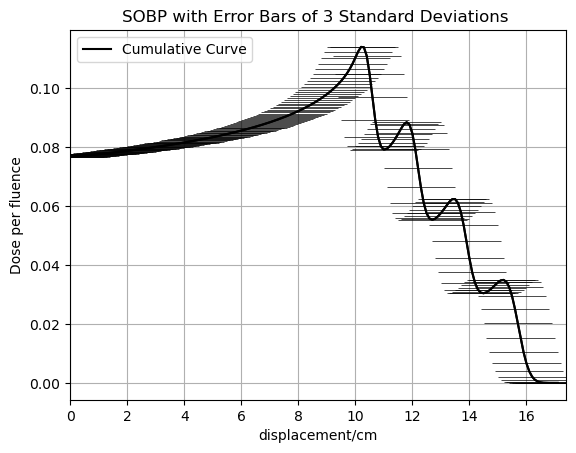

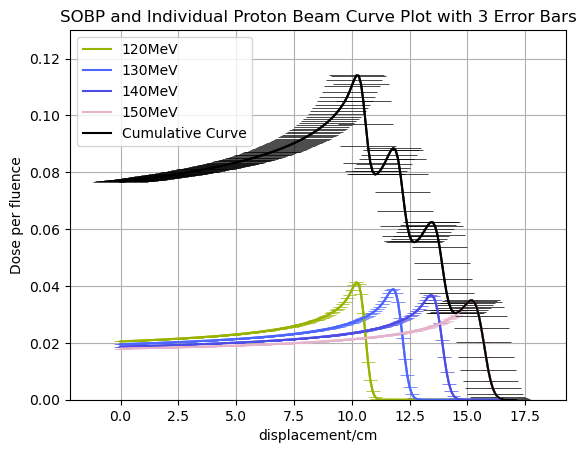

In [37]:
eVals = [120,130,140,150];nStandardDeviations = 3; theta = 0.1

PlotCumulativeCurveNormEB(eVals,nStandardDeviations,theta)
plt.show()

PlotCumulativeCurveAndIndNormEB(eVals, nStandardDeviations,theta)
plt.show()

#### Accuracy
Using what we have created above we can asses Accuracy of a SOBP to be within a target range. We do this futher use of the previously stated fact,'$99.7$% of the data of a Normal distribution lies within $3$ Standard Deviations of the mean'. Hence, to be sure to a $99.7$% accuracy, we must reduce the target range by $6$ Standard deviations (reduction in $3$ Standard Deviations from upper bound and addition of $3$ Standard Deviations on the lower bound).
Should we find a 'best' SOBP within the reduced target range, we can therefore be sure to a $99.7$% accuracy that such SOBP is the best curve for the entirety of the target range. 

As we progress we create a new  Optimiser() to solve this problem.

###### First we need another CustomBox Function:

In [38]:
def PlotCustomBoxError(upper,lower,dose):
    plt.vlines(x=lower,ymin = 0,ymax = dose, color='b', linestyles='dashed')
    plt.vlines(x=upper,ymin = 0,ymax = dose, color='b', linestyles='dashed')

###### Interactive Optimiser function that takes into acount accuracy:

In [39]:
def OptimiserWithUncertainty(): 
    # Takes no arguments, returns DataFrame of SOBP curves in rank order.
    
    theta = float(input("Theta value: "))
    nStnDev = int(input("Amount of standard deviations (1,2 OR 3): "))
    option = int(input("Choose Simple Box? \n 1:yes \n 0:no \n"))

    if option == 0:
        
        upper = round(float(input( "upper Bound Value (float): ")),2) 
        lower = round(float(input( "lower Bound Value (float): ")),2)
        dose = round(float(input( "Dose Value (float): ")),2)
        mxNo = CalculateMaxCurves(dose, upper, energyData) #max # of curves i should use to get the SOBP else dosage too high
        print("Your given doseage has upper bound number of curves needed as " + str(mxNo))
        r = int(input("Number of curves to use (maximum is 5)? :")) # change to the optimised version later

        upperErr = upper - r*nStnDev*theta
        lowerErr = lower + r*nStnDev*theta 
        
        
       
        
    
    elif option == 1:
        
        upper = 15
        lower = 12
        dose = 0.1 
        
        mxNo = CalculateMaxCurves(dose, upper, energyData) #max # of curves i should use to get the SOBP else dosage too high
        print("Your given doseage has upper bound number of curves needed as " + str(mxNo))
        r = int(input("Number of curves to use (maximum is 5)? :")) # change to the optimised version later
        
        upperErr = upper - r*nStnDev*theta
        lowerErr = lower + r*nStnDev*theta 
        
    
    elif (upper - lower)/(nStnDev*2) <= (theta):
        print("No solutions, Error range too large")
        return()
    
    #trim the range of energyValues()
    df = RestrictDfRanges(energyData,lowerErr,upperErr)
    
    #defining variables:
    cdf = pd.DataFrame() #dataFrame to contain the energy Values and stats about the SOBP 
    
    eZeroOne = None
    eZeroTwo = None
    eZeroThree = None
    eZeroFour = None
    eZeroFive = None
    curveList = [] # list used to hold all PBC in calculation for SOBP curve
    eZeroList = [] # list used to hold all eZero values
    uncerList = [] # list used to hold the uncertainty value for every curve
     
    #Combinations
    n = len(df.eZero) # the amount of eZero values to iterate through 
    print(" r = "+str(r)+ "\n n = "+ str(n))
    
   
    for i in range(n-1):
        eZeroList.append(df.eZero.iloc[i])
    # eZeroList now hold all eZero values
    
    combList = list(it.combinations_with_replacement(eZeroList,r))
    #comb list now holds all the combinations of values in eZeroList.
    
    print("Total amount of combinations = " + str(len(combList))) 

    for combo in combList:
        curveList =[] 
        z = CalculateXAxisList(combo)
            
        for eZero in combo:
            curve,df = CalculateMultiplePBC(eZero,z, df) # Calculate individual PBC
            curveList.append(curve) 

        sobp = sum(curveList) # Calculate SOBP
            
        stdDev, avgDist, percentageAboveDose= CalculateInfo(dose,lower, upper,sobp) # Calculate the info for the df later

        #append data to cdf
        if r == 2:
            eZeroOne = combo[0];eZeroTwo = combo[1]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 3:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 4: 
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r ==5:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];eZeroFive = combo[4]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                     "eZeroFive": eZeroFive,"standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,
                     "percentageAboveDoseLine":percentageAboveDose}
            
        uncerList.append(r*nStnDev*theta)
        beamData = pd.Series(data = datum,index = datum.keys())
        cdf = pd.concat([cdf, beamData.to_frame().T], ignore_index=True)


    #sort the df by percentageAboveDoseLine values
    cdf["TotalUncertainty"] = uncerList
    cdf = cdf.sort_values(by = ['percentageAboveDoseLine','averageDisplacementFromDose'], ascending = [False,True])
    
    for j in range(3): #for the top 3 curves  
        eVals = []          
        for i in range(r): # take the n curves that make the sobp
            eVals.append(cdf.iloc[j][i]) #add the eZeros to a list 
        print("BEST CURVE NUMBER "+str(j+1))
        PlotCumulativeCurveAndIndNormEB(eVals,nStnDev,theta) #Plot the List 
        PlotCustomBoxError(upperErr,lowerErr,dose)
        PlotCustomBox(upper,lower,dose)
        plt.show()
    return(cdf) 

In [40]:
#df = OptimiserWithUncertainty()
#print(df.head(3))

#### Example Question: With 95% Accuracy, what is the best curve to solve SimpleBox()? 
$95$% accuracy implies we are using $2$ standard deviations from the mean to contain our data.
However without the standard deviation given in the question we are unable to answer this question fully. 
If we set $\theta = 0$, we observe that the reduced target range is equal to the target range; no reduction in range and no error range.
However if we set $\theta = a\ge0$ st $Range - Error Range\le0$, this allows for $0$ curves to be in the dataframe and hence there are no solutions.
 

$Check$ $back$ $soon!$

# 

24/06/22
# Calculating Optimal Intensities:


#### new function to return the value of the curve at some point of some evalue to allow for the quadrature function to do its magic. 

### Function that returns continous value of the curve.

In [41]:
def Functionb(x,eZero):
    #eZero = eValueGlobal
    #secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    rZero = alpha*(pow(eZero,p))*1.1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)

    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))

    #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    y =  (phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
    1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
    ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2)
    return(y)
    
    

##### Function used to fill M by multiplying two bragg peaks together:

In [42]:
    
def Function3b(x,eZeroi,eZeroj): #used to fill M for the quadrature method.  
    a = Functionb(x,eZeroi)
    b = Functionb(x,eZeroj)
    c = a*b
    return(c)

#### Error spotted in plots between discrete and continous variations. To be worked on (replacing prior function using old plottinf fucntion)

   eZero      rZero     sigma   phiZero
0  150.0  15.635228  0.318135  1.187623


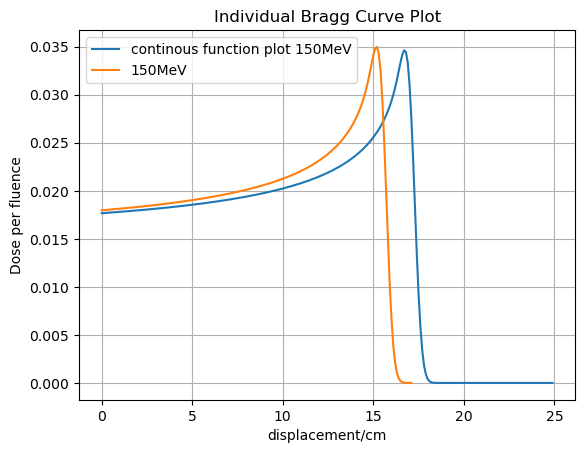

In [43]:
z = np.arange(0,25,0.1)
plt.plot(z,Functionb(z,150), label = "continous function plot 150MeV")
PlotCurve(150)

##### minimising the system:    
## $\underline{M_{ij}} = \theta\int_Tb_i(x) b_j(x) .dx$  s.t. $\theta = 1$ 

In [44]:
    
def OptimiseLAb(lower, upper,dose, eVals): 
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        
        for j in range(n): # for n evaleus 
            
            
            val,err = integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j]))
            m[i,j] = val
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        plt.plot(z,dList[i], label = str(eVals[i])+" MeV", alpha = 1)
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,dose+0.3])
    plt.xlim([0,18])
    
    return(m,omega,f,d)



def OptimiseLAbNoPlot(lower, upper,dose, eVals): 
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 
            
            val,err = integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j]))
            m[i,j] = val
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        ###SeteValGlobal(eVals[j]) #Function(), Function4()
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
   
    return(m,omega,f,d)

The unconstrained solution is optimal.
Final cost 3.9120e-34, first-order optimality 6.81e-20


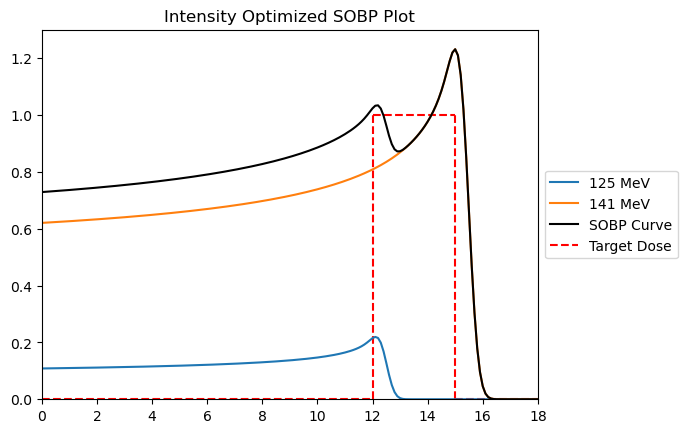

In [45]:
eVals = [125,141]
lower = 12;upper = 15; dose = 1
m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)

##### Displaying Data

In [46]:
print("Matrix M: \n",m)
print("f =" + str(f))
print("omega (weights) = "+ str(omega))

Matrix M: 
 [[0.00069739 0.00053495]
 [0.00053495 0.00238619]]
f =[0.02200938 0.08393509]
omega (weights) = [ 5.52849577 33.93590178]


#### Intensity Progression - Number of Curves, $n$ increases

[124.0, 141]
The unconstrained solution is optimal.
Final cost 1.3391e-34, first-order optimality 3.63e-20


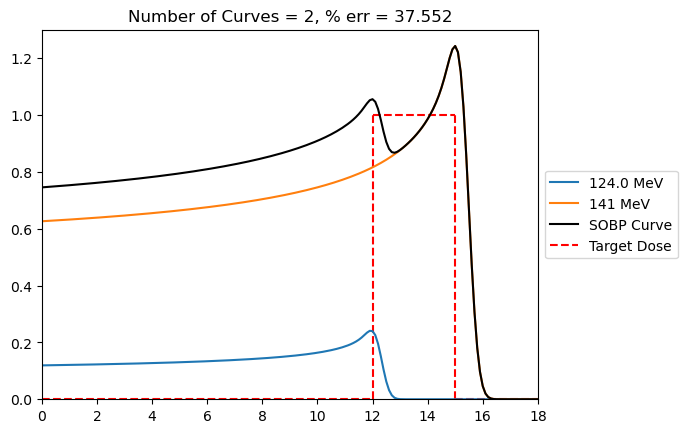

[124.0, 132.5, 141]
The unconstrained solution is optimal.
Final cost 1.8838e-33, first-order optimality 1.75e-19


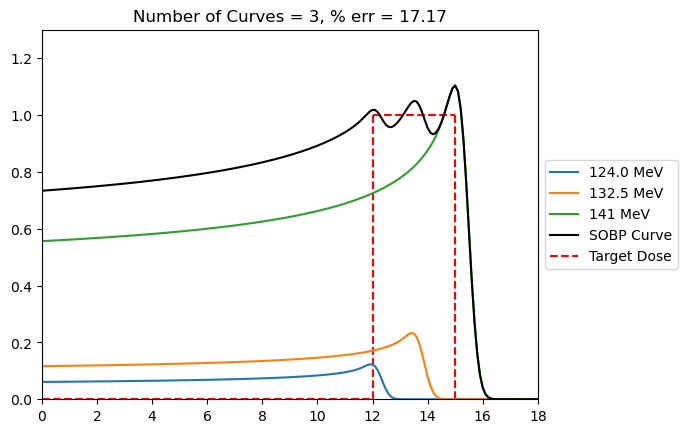

[124.0, 129.66666666666666, 135.33333333333334, 141]
The unconstrained solution is optimal.
Final cost 3.7796e-33, first-order optimality 2.90e-19


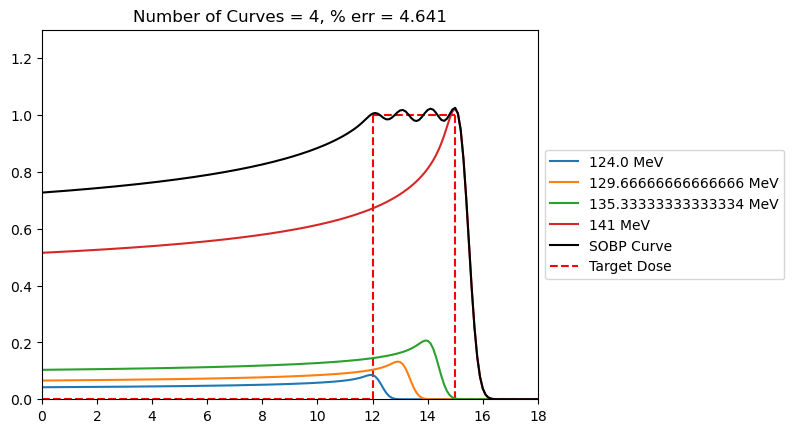

[124.0, 128.25, 132.5, 136.75, 141]
The unconstrained solution is optimal.
Final cost 1.8357e-33, first-order optimality 2.26e-19


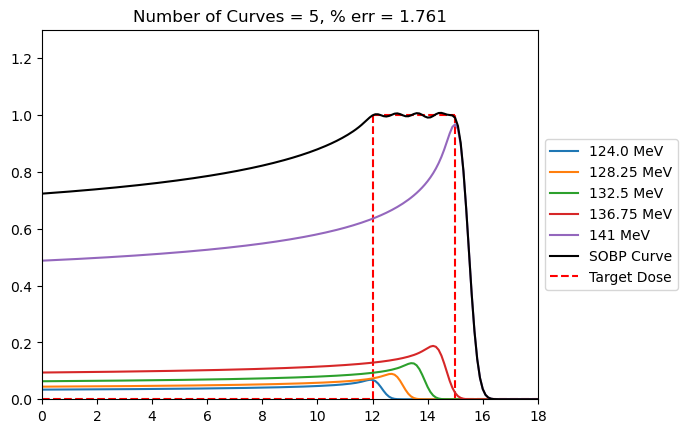

[124.0, 127.4, 130.8, 134.2, 137.6, 141]
The unconstrained solution is optimal.
Final cost 4.0926e-34, first-order optimality 1.23e-19


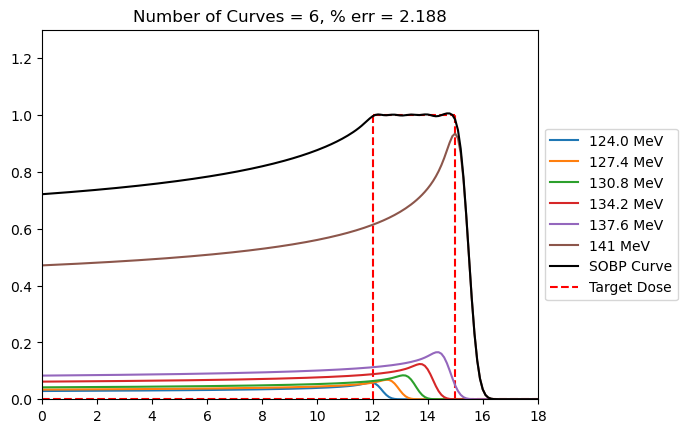

[124.0, 126.83333333333333, 129.66666666666666, 132.5, 135.33333333333334, 138.16666666666666, 141]
The unconstrained solution is optimal.
Final cost 4.6681e-32, first-order optimality 1.47e-18


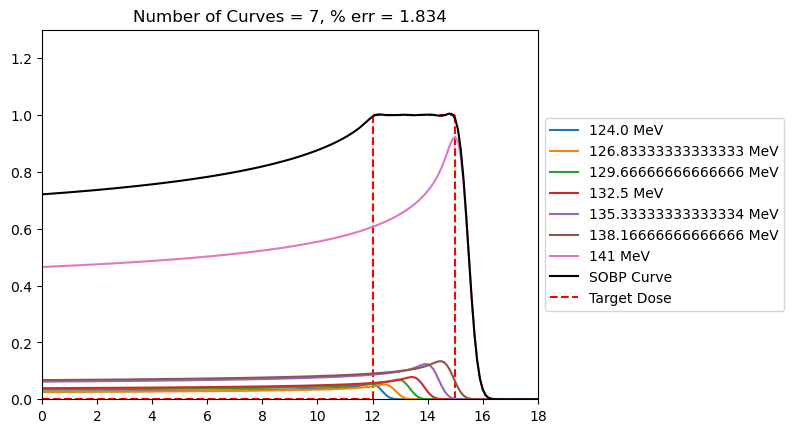

[124.0, 126.42857142857143, 128.85714285714286, 131.28571428571428, 133.71428571428572, 136.14285714285714, 138.57142857142858, 141]
The unconstrained solution is optimal.
Final cost 1.0358e-32, first-order optimality 7.04e-19


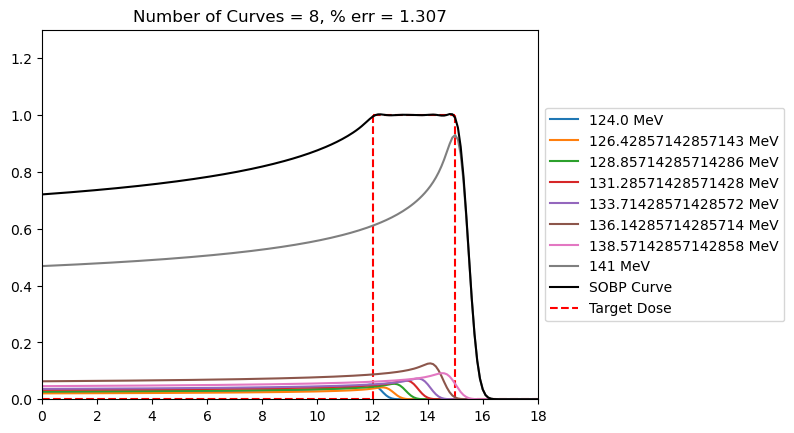

[124.0, 126.125, 128.25, 130.375, 132.5, 134.625, 136.75, 138.875, 141]
The unconstrained solution is optimal.
Final cost 3.8460e-32, first-order optimality 1.51e-18


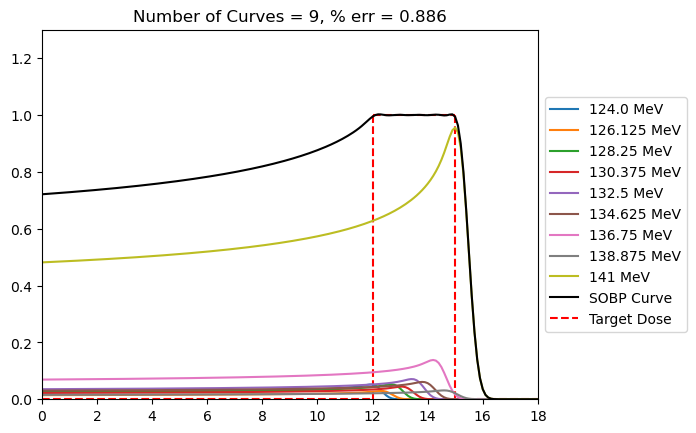

[124.0, 125.88888888888889, 127.77777777777777, 129.66666666666666, 131.55555555555554, 133.44444444444446, 135.33333333333334, 137.22222222222223, 139.11111111111111, 141]
The first-order optimality measure is less than `tol`.
Number of iterations 5, initial cost 6.9620e-05, final cost 5.5927e-13, first-order optimality 2.33e-11.


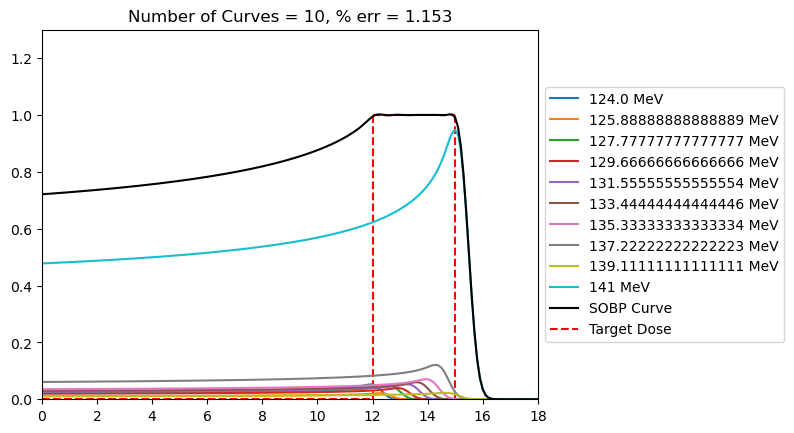

[124.0, 125.7, 127.4, 129.1, 130.8, 132.5, 134.2, 135.9, 137.6, 139.3, 141]
The first-order optimality measure is less than `tol`.
Number of iterations 11, initial cost 1.3550e-03, final cost 8.9656e-12, first-order optimality 4.68e-11.


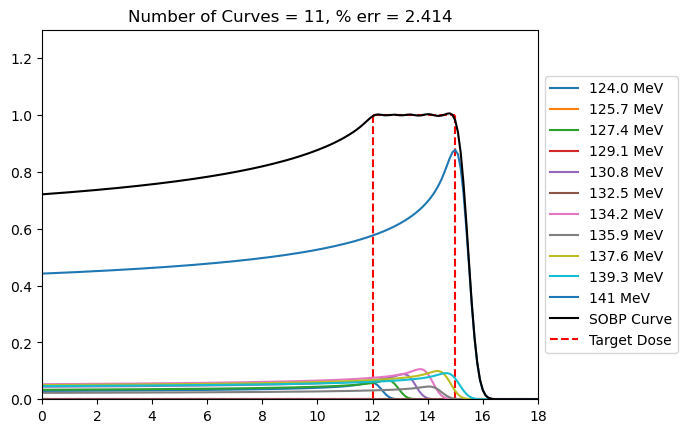

[124.0, 125.54545454545455, 127.0909090909091, 128.63636363636363, 130.1818181818182, 131.72727272727272, 133.27272727272728, 134.8181818181818, 136.36363636363637, 137.9090909090909, 139.45454545454547, 141]
The first-order optimality measure is less than `tol`.
Number of iterations 15, initial cost 3.8051e-03, final cost 5.1170e-12, first-order optimality 2.60e-11.


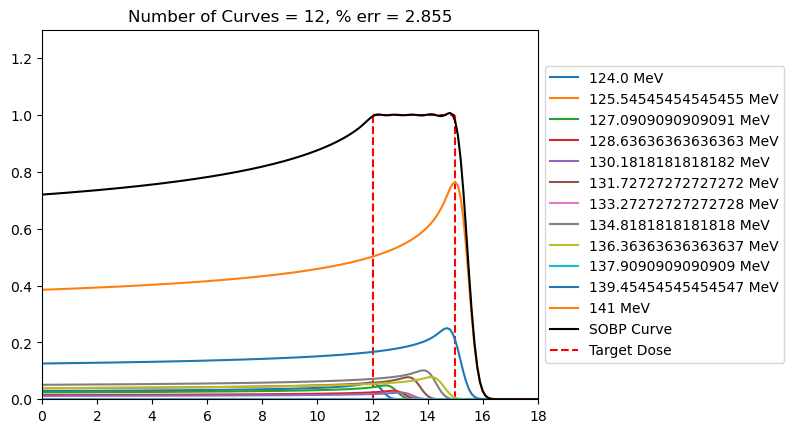

[124.0, 125.41666666666667, 126.83333333333333, 128.25, 129.66666666666666, 131.08333333333334, 132.5, 133.91666666666666, 135.33333333333334, 136.75, 138.16666666666666, 139.58333333333334, 141]
The first-order optimality measure is less than `tol`.
Number of iterations 25, initial cost 3.1301e-02, final cost 4.4189e-11, first-order optimality 4.92e-11.


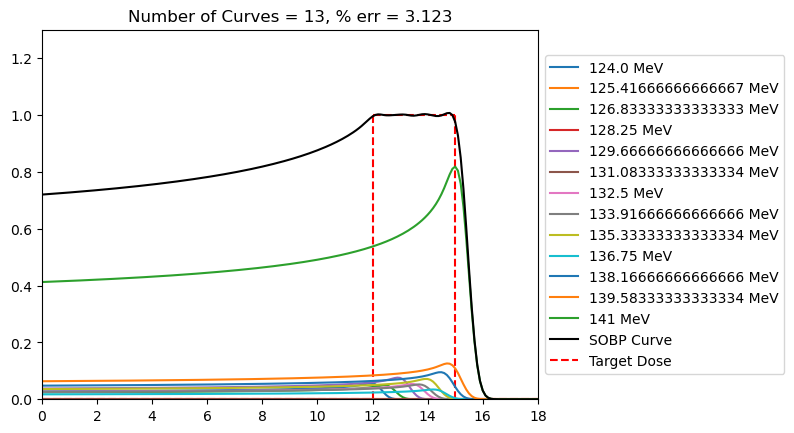

[124.0, 125.3076923076923, 126.61538461538461, 127.92307692307692, 129.23076923076923, 130.53846153846155, 131.84615384615384, 133.15384615384616, 134.46153846153845, 135.76923076923077, 137.07692307692307, 138.3846153846154, 139.69230769230768, 141]
The first-order optimality measure is less than `tol`.
Number of iterations 18, initial cost 3.1472e-02, final cost 1.4394e-11, first-order optimality 9.50e-11.


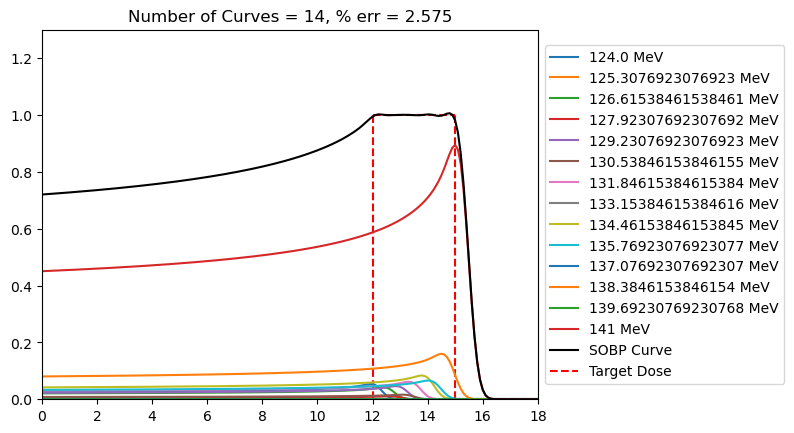

[124.0, 125.21428571428571, 126.42857142857143, 127.64285714285714, 128.85714285714286, 130.07142857142858, 131.28571428571428, 132.5, 133.71428571428572, 134.92857142857142, 136.14285714285714, 137.35714285714286, 138.57142857142858, 139.78571428571428, 141]
The first-order optimality measure is less than `tol`.
Number of iterations 17, initial cost 5.3032e-01, final cost 3.7702e-11, first-order optimality 9.62e-11.


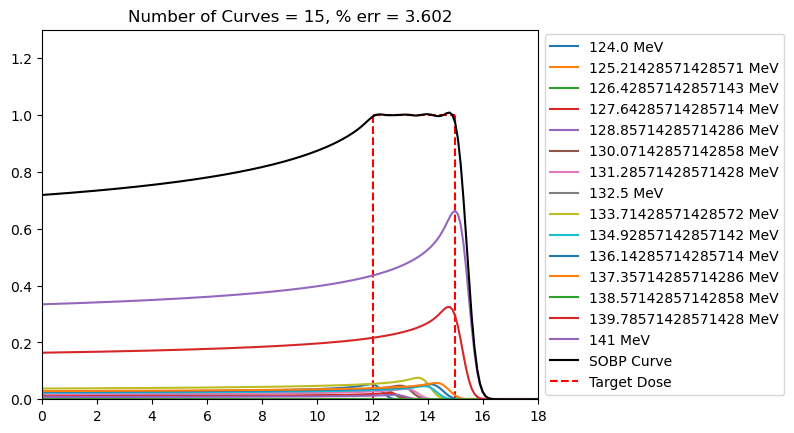

[124.0, 125.13333333333334, 126.26666666666667, 127.4, 128.53333333333333, 129.66666666666666, 130.8, 131.93333333333334, 133.06666666666666, 134.2, 135.33333333333334, 136.46666666666667, 137.6, 138.73333333333332, 139.86666666666667, 141]
The first-order optimality measure is less than `tol`.
Number of iterations 23, initial cost 2.7636e-01, final cost 3.2828e-11, first-order optimality 3.53e-11.


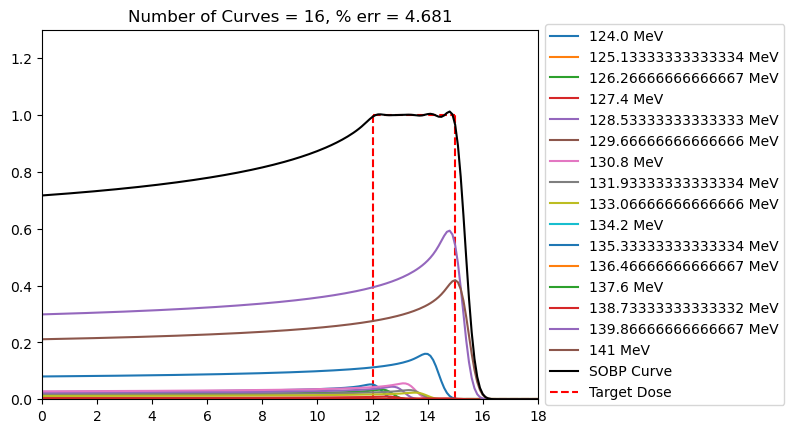

[124.0, 125.0625, 126.125, 127.1875, 128.25, 129.3125, 130.375, 131.4375, 132.5, 133.5625, 134.625, 135.6875, 136.75, 137.8125, 138.875, 139.9375, 141]
The first-order optimality measure is less than `tol`.
Number of iterations 24, initial cost 1.1880e+01, final cost 3.1503e-12, first-order optimality 1.20e-11.


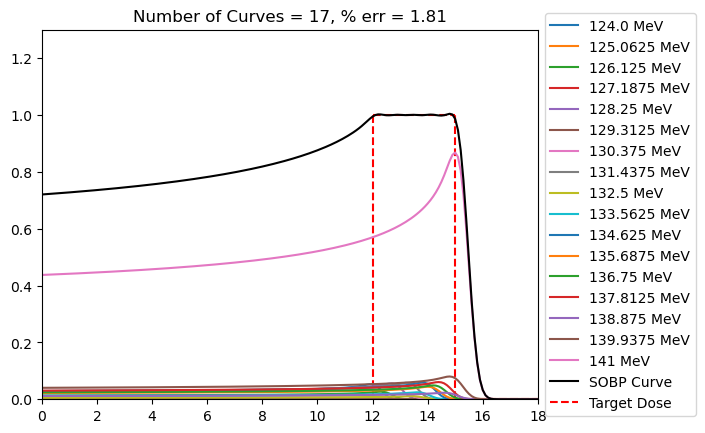

[124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141]
The first-order optimality measure is less than `tol`.
Number of iterations 24, initial cost 8.7243e+00, final cost 2.1162e-11, first-order optimality 2.61e-11.


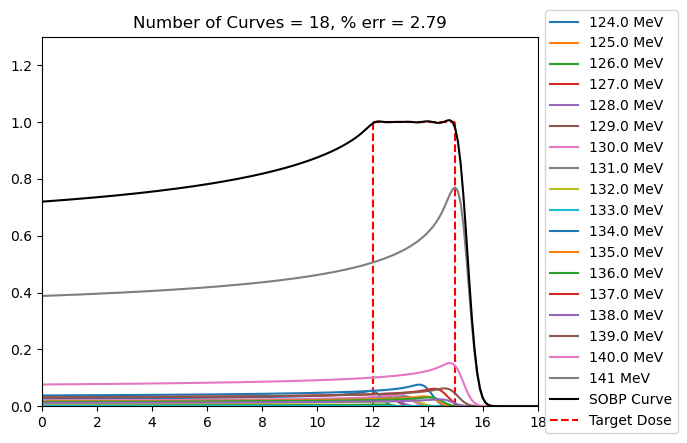

In [47]:
lower = 12;upper = 15; dose = 1; eZeroUpper = 141;eZeroLower = 124
n = eZeroUpper-eZeroLower
eVals = []
for i in range(1,n+1):
    eVals = []
    for j in range(i):
        eVals.append(eZeroLower+(j)*n/i)
    eVals.append(eZeroUpper)
    print(eVals)
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    restricted = d[120:151]
    err = round(abs(max(restricted) - min(restricted))*100,3)
    plt.title("Number of Curves = "+ str(len(eVals)) +", % err = " + str(err))
    
    plt.show()

#### Example of Optimizer taking in MANY n without taking into account the minimisation of the domain $\Omega$ \ $T$  

The first-order optimality measure is less than `tol`.
Number of iterations 11, initial cost 3.6081e-01, final cost 1.0765e-12, first-order optimality 8.51e-11.


TypeError: 'bool' object is not iterable

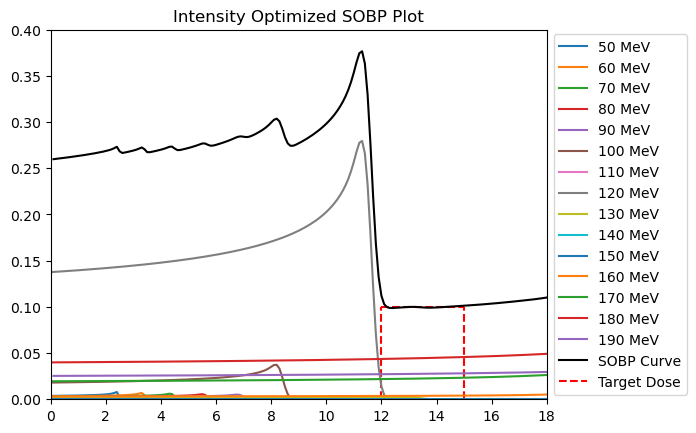

In [48]:
eVals = np.arange(50,200,10)
lower = 12;upper = 15; dose = 0.1
m,b,f,d =OptimiseLAb(lower,upper,dose,eVals)
plt.legend(False)

#### Introducing the ratio of the domains to the optimizer


# $\underline{M_{ij}} = \theta\int_Tb_i(x) b_j(x) .dx + \phi \int_{\tau}b_i(x) b_j(x) .dx $

## $ s.t. \tau = \Omega \not T$

In [ ]:
def OptimiseLARatioB(lower, upper,dose, eVals,theta,phi):
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 
             
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = theta*valTarget + phi*(valUpper+ valLower)
            m[i,j] = valCorrected
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        ###SeteValGlobal(eVals[j]) #Function(), Function4()
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot. Phi = "+ str(phi))
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,dose+0.3])
    plt.xlim([0,18])
    
    return(m,omega,f,d)


In [ ]:
eVals = [123,125,127,129,131,133,135,137,139,141]
lower = 12;upper = 15; dose = 1;theta = 1; phi = 1;
m,omega,f,d =OptimiseLARatioB(lower,upper,dose,eVals,theta,phi)

#### Ratio progression - $\phi$ increases

In [ ]:
phiList = list(np.arange(0,0.1,0.01))
eVals = [123,125,127,129,131,133,135,137,139,141]
lower = 12;upper = 15; dose = 1;theta = 1

for phi in phiList:
    m,omega,f,d =OptimiseLARatioB(lower,upper,dose,eVals,theta,phi)
    plt.show()

## Error Stagneation in   $\underline{M_{ij}} = \theta\int_Tb_i(x) b_j(x) .dx$  s.t. $\theta = 1$,  model.

In [ ]:
def GetD(x,omega,eVals):
    lst = []
    for i in range(len(eVals)): # for every value
        
        lst.append(omega[i]*Functionb(x,eVals[i])) # hold data in list 
    continousD = sum(lst) # y = f(x)
    return(continousD)

def GetDMinusOneNormedSquared(x,omega,eVals):
    d = GetD(x,omega,eVals)
    y = pow(abs(d-1),2)
    return(y)

x = np.arange(0,10)
GetDMinusOneNormedSquared(x,omega,eVals)

def GetQuadratureTSqrt(omega,eVals):
    lower = 12;upper = 15
    val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals))
    y = np.sqrt(val)
    return(y)



In [ ]:
def FunctionDeriv(x,eVal):

    h = 0.00001
    deriv = (Functionb((x+h),eVal) - Functionb(x,eVal))/(h)
    
    return(deriv)
    
def FunctionDeriv3(x,eVals):
    a = FunctionDeriv(x,eVals[0])
    b = FunctionDeriv(x,eVals[1])
    return(a*b)
    

In [ ]:
def PlotErrorStagnation(lower,upper,dose,eZeroLower,eZeroUpper):
    n = eZeroUpper-eZeroLower
    eVals = []
    yValues = []
    x = 0

    for i in range(1,n+1):
        eVals = []
        for j in range(i):
            eVals.append(123+(j)*n/i)
        eVals.append(141)
        print(str(len(eVals))+" Curves")
        print(str(eVals))
        m,omega,f,d =OptimiseLAbNoPlot(lower,upper,dose,eVals)
        yValues.append(GetQuadratureTSqrt(omega,eVals))
    plt.show()#
    
    
    
    x = np.arange(2,n+2)
    
    #Error stagnation plot
    plt.plot(x,yValues)
    #print(yValues)
    plt.yscale('log')
    plt.ylabel("Root Quadrature of Square Norm of (d-1)")
    plt.xlabel("n Curves used to make SOBP curve")
    plt.title("Error via PlotErrorStagnation. Log y scale only")
    plt.xticks(x)
    plt.grid(True)
    
    plt.show()
    
    # All Bragg peaks used
    plt.figure()
    x = np.arange(0,20,0.05)
    for i in eVals:
        plt.plot(x,Functionb(x,i), label = str(i)+ "MeV")
    plt.title("All Bragg Curves used with unit Intensity.")
    plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    
   
    
    #finding best and other n for error plots  
    
    nMin = min(yValues)
    nmax = max(yValues)
    
    for i in range(len(yValues)):
        if yValues[i] == min(yValues):
            n = i+2
        
        elif yValues[i] == max(yValues):
            n3 = i+2
        
    yValues.remove(yValues[n-2])
    for i in range(len(yValues)):

        if yValues[i] == min(yValues):
            n2 = i+2
            
        
    
    difference = eZeroUpper-eZeroLower
    
     # Minimal error plot 
    plt.figure()
    print("n_least error = "+ str(n))
    eVals = []
    for j in range(n-1):
        eVals.append(eZeroLower+(j)*difference/n)
    eVals.append(eZeroUpper)
    print(len(eVals))
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    plt.title("Most Minimized Error Curve Plot, n = "+ str(n))
    plt.show()
    
    
    # Second best minimal error plot
    plt.figure()
    
    eVals = []
    for j in range(n2-1):
        eVals.append(eZeroLower+(j)*difference/n2)
        
    eVals.append(eZeroUpper)
    print(len(eVals))#
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    plt.title("Second Most Minimized Error Plot, n = "+ str(n2))
    plt.show()
   
    #Worst minimal error plot from minimised solution
    plt.figure()
    
    eVals = []
    for j in range(n3-1):
        eVals.append(eZeroLower+(j)*difference/n2)
        
    eVals.append(eZeroUpper)
    print(len(eVals))#
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    plt.title("highest error Plot of minimised solution, n = "+ str(n3))
    plt.show()
    
    return(yValues)

### Example of Error Stagnation 

In [ ]:
lower = 12;upper=15;dose = 1;eZeroLower = 123;eZeroUpper = 141

yValues = PlotErrorStagnation(lower,upper,dose,eZeroLower,eZeroUpper)



# Penalise Derivative

# $\underline{M_{ij}} = \theta\int_Tb_i(x) b_j(x) .dx + \phi \int_{\tau}b_i(x) b_j(x) .dx + \psi\int_T b_i'(x)b_j'(x)$


#### Aproximation of the Derivative

In [ ]:
eZero = 145
x = np.arange(0,25,0.1)
y = Functionb(x,eZero)
plt.plot(x,y)
dydx = FunctionDeriv(x,eZero)
plt.plot(x,dydx)


dydxZero = 0
for i in range(len(x)):
    if y[i] == max(y):
        xMax = i/10
plt.vlines(x=xMax,ymin=-0.04,ymax = 0.04,linestyles="dashed",color = "r")
plt.show()
plt.figure()
plt.plot(x,y)
plt.plot(x,dydx)
plt.vlines(x=xMax,ymin=-0.04,ymax = 0.04,linestyles="dashed",color = "r")
plt.hlines(y = 0, xmin = 15,xmax = 17, linestyles="dashed", color = "r")
plt.xlim([15,17])
plt.ylim([-0.01,0.01])

#### Find % error here

##### PenaliseDerivative Continued ()

In [ ]:
def PenalizeDerivaive(lower,upper,dose,eVals,theta,phi,psi):
    
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*2,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = theta*valTarget + phi*(valUpper+ valLower)
            
            valDeriv,err = integrate.quad(FunctionDeriv3,lower,upper,args = (eValsij))
            valCorrected = valCorrected + psi*(valDeriv)
            
            m[i,j] = valCorrected
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,2])
    plt.xlim([0,18])
    
    return(m,omega,f,d)

    

### PenaliseDerivative() Progression - $\psi$ increases

In [ ]:
eVals = list(np.arange(124,141,10))

#FunctionDeriv3(1,eVals)
psi = np.arange(-4,3,1, dtype = float)
for i in psi:
    m,omega,f,d = PenalizeDerivaive(lower,upper,dose,eVals,1,0,10**i)
    print("omega (weights) = "+ str(omega))
    plt.title("psi = 10**"+ str(i))
    plt.show()

# Penalise Derivative More
## $\underline{M_{ij}} = \theta\int_Td_i d_j .dx + \phi \int_{\tau}d_i d_j .dx + \psi\int_T |b_i'(x)|^{p_2-2}b_i'(x)b_j'(x)$


## define $p_2$

## $\frac{1}{p_2} + \frac{1}{q} = 1 \implies p_2 = \frac{q}{q-1}$

In [ ]:
###defining p's and q's
qList = list(np.arange(2,11,1))
p2List = []
for q in qList:
    p2 = round(1/(1-(1/q)),2)
    p2List.append(p2)
print(qList,p2List)

In [ ]:
def TristanFunciton(x,eZeroij,p2):
    deriv = FunctionDeriv(x,eZeroij[0])
    absolute = abs(deriv)
    lamda = pow(absolute,(p2-2))
    rho = FunctionDeriv3(x,eZeroij)
    delta = lamda* rho
    
    return(delta)

In [ ]:
def PenalizeDerivaiveMore(lower,upper,dose,eVals,theta,phi,psi,p2):
    
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.2,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            #print(valTarget)
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = (theta*valTarget) + phi*(valUpper+ valLower)
            #print(valCorrected)
            valDeriv,err = integrate.quad(TristanFunciton,lower,upper,args = (eValsij,p2))
            valCorrected = valCorrected + psi*(valDeriv)
            #print(valCorrected)
            m[i,j] = valCorrected
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim([0,2])
    #plt.xlim([0,18])
    
    return(m,omega,f,d)

    

### PenaliseDerivativeMore Progression - $\psi$ and $P_2$ increases

eVals = [124,130,135,140]
#lower,upper,dose,eVals,theta,phi,psi,p2
lower = 12;upper = 15; dose = 1;theta = 1;phi = 0;psi = 0; p2 = 1.5

psi = np.arange(-2,3,1, dtype = float)
for i in psi:    #lower,upper,dose,eVals,theta,phi,psi,p2
    for p2 in p2List:
        psi = 10**i
        m,omega,f,d = PenalizeDerivaiveMore(lower,upper,dose,eVals,theta,phi,psi,p2)
        plt.title("psi = 10**"+ str(i)+ ". p_2 = {2,1.5,...,1.11}")
    plt.show()


- python library needed of all functions
# PenaliseDerivativeEvenMore()
###### Need a new fucntion(s) to solve the non linear system
###### Continuation Argument:
First we need the continous d to be returned.

# $\underline{\hat{N}_{ij}} = \theta\int_Tb_i(x) b_j(x) .dx + \phi \int_{\tau}b_i(x) b_j(x) .dx + \psi\int_T |\hat{d}'(x)|^{p_{2_0}-2}b_i'(x)b_j'(x)$

### Where $\hat{d}(x) = \sum{\hat{\omega}_ib_i(x)} $ Solves $\hat{N}\omega = \underline{f}$ for $p_{2_1} > p_{2_0}$

In [ ]:

def GetQuadratureTSqrt(omega,eVals):
    lower = 12;upper = 15
    val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals))
    print(err)
    y = np.sqrt(val)
    return(y)

def GetQuadratureTSqrtPlusPsi(omega,eVals,psi):
    lower = 12;upper = 15
    val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals)) 
    val2,err2 = integrate.quad(GetdPrimeNormSquared,12,15,args = (omega,eVals,psi))
    y = (val + val2)
    return(y)

def GetdPrimeNormSquared(x,omega,eVals,psi):
    dPrime = FunctionDeriv2(x,eVals,omega)
    y = psi*pow(abs(dPrime),2)
    
    return(y)

### New functions to return the derivative of the d's and the complicated part of the $\psi$ term

In [ ]:
def FunctionDeriv2(x,eVals,omega):

    h = 0.001
    deriv = (GetD((x+h),omega,eVals) - GetD(x,omega,eVals))/(h)
    
    return(deriv)

def FunctionDPrimeNormSq(x,eZero,p2):
    dPrime = pow(abs(FunctionDeriv(x,eZero)),p2-2)
    dPrime = dPrime + TristanFunciton
    return(dPrime)


def TristanFunciton2(x,eZeroij,p2,eVals,omega):
    if p2 != 2:
        deriv = pow(abs(FunctionDeriv2(x,eVals,omega)),p2-2)
        rho = FunctionDeriv3(x,eZeroij)
        delta = deriv* rho
    else:
        deriv = 1
        rho = FunctionDeriv3(x,eZeroij)
        delta = deriv* rho
    
    return(delta)

In [ ]:
def PenaliseDerivativeEvenMore(d,p2,lower,upper,dose,eVals,theta,phi,psi,oldOmega):
    
    # definine variables 
    n = len(eVals)
    
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for N
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            
            #### THETA
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            #print(valTarget)
            #### PHI
            #valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            #valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
        
            #### PSI
            valDeriv,err = integrate.quad(TristanFunciton2,lower,upper,args = (eValsij,p2,eVals,oldOmega),limit = 10)
            #print(valDeriv)
            
            valCorrected = theta*(valTarget)  + psi*(valDeriv) #+ phi*(valUpper+ valLower)
            #print("vc",valCorrected)
            m[i,j] = valCorrected
    
   
    ######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(x,eVals[i]))) #collect the di's
        plt.plot(x,dList[i], alpha = 0.2, color = "b")

    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    r = round(float(np.random.uniform(0,1,1)),1)
    g = round(float(np.random.uniform(0,1,1)),1)
    b = round(float(np.random.uniform(0,1,1)),1)
    plt.plot(x,d, label = "p_2:"+str(p2)+"psi:"+str(psi),color =(r,g,b)) #plot
    
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("p_2 = "+str(p2)+". Psi = "+str(psi) +". Theta = "+ str(theta)+ "Phi = 0")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim([0,1.25])
    #plt.xlim([0,18])
    
    
    return(d,m,omega,f)

In [ ]:
def PenaliseDerivativeEvenMoreNoPlot(d,p2,lower,upper,dose,eVals,theta,phi,psi,oldOmega):
    
    # definine variables 
    n = len(eVals)
    
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for N
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            
            #### THETA
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            #print(valTarget)
            #### PHI
            #valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            #valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
        
            #### PSI
            valDeriv,err = integrate.quad(TristanFunciton2,lower,upper,args = (eValsij,p2,eVals,oldOmega),limit = 10)
            #print(valDeriv)
            
            valCorrected = theta*(valTarget)  + psi*(valDeriv) #+ phi*(valUpper+ valLower)
            #print("vc",valCorrected)
            m[i,j] = valCorrected
    
   
    ######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(x,eVals[i]))) #collect the di's
        #plt.plot(x,dList[i], alpha = 0.2, color = "b")

    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    
    return(d,m,omega,f)

#### Errors seem to be caused int he PenaliseDerivativeEvenMore() Function but the cell below goes step by step and shows there is no problem. Tritans thoughts here. Think its just the nature of the curve d having such a harsh decline.

In [ ]:
eVals = [125,130,135,140]
eValsij = [120,130]
p2 = 1.5;psi = 0;theta = 1;lower = 12;upper = 15
omega = [1,1,1,1]
TristanFunciton2(np.arange(0,30,0.1),eValsij,1.5,eVals,omega)
ans,err =integrate.quad(TristanFunciton2,12,15,args = (eValsij,2,eVals,omega))
ans

#### Simple Example of the OptimiseDerivativeEvenMore()

In [ ]:
x = np.arange(0,20,0.1)
eVals = [125,130,135,140];lower = 12;upper = 15;dose =1;theta = 1;phi = 0;p2 = 2;psi = 1#
dZero,m,omega,f = PenaliseDerivativeEvenMore(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
p2 = 1.5
plt.show()
d,m,omega,f = PenaliseDerivativeEvenMore(dZero,p2,lower,upper,dose,eVals,theta,phi,psi,omega)



### PenaliseDerivativeEvenMore $p_2$ and $\psi$ progression

 x = np.arange(0,30,0.1)
eVals = [124,128,132,136,141];lower = 12;upper = 15;dose =1;theta = 1;phi = 0; psi = 1
#dZero,m,omega,f = DZero(x,lower,upper,dose,eVals)
psiList = list(np.arange(0,7,1))

#dZero,m,omega,f =PenaliseDerivativeEvenMore(dZero,p2,lower,upper,dose,eVals,theta,phi,0,omega)
#plt.plot(dZero)
#plt.show()
#print("dZero = ",dZero)
#d,m,omega,f= PenaliseDerivativeEvenMore(dZero,p2,lower,upper,dose,eVals,theta,phi,0,omega)
#plt.plot(d)

for p2 in p2List:
    for exp in psiList:
        psi = 2**exp
        print(psi)
    
        if p2 == 2:

            d,m,omega,f= PenaliseDerivativeEvenMore(d,p2,lower,upper,dose,eVals,theta,phi,psi,omega)
        else:

            d,m,omega,f= PenaliseDerivativeEvenMore(d,p2,lower,upper,dose,eVals,theta,phi,psi,omega)
    plt.show()
#print(omega)

### Show Tristan:

In [ ]:
def PlotErrorStagnation2(lower,upper,dose,eZeroLower,eZeroUpper):
    #deining variables 
    x = np.arange(0,30,0.1)
    theta = 1;phi = 0; psi = 1; p2 = 2
    
    psiList = list(np.linspace(10**-6,10**-2,41)) # psi values over the range we care about 
    print(psi)
    difference = eZeroUpper-eZeroLower
    eVals = []
    yValues = []
    x = 0
    n = 10 # number of curves set to 10 as found by previous error Stagnation plot 

    #########################################################################
    # set evals
    for j in range(n-1):
        eVals.append(eZeroLower+(j)*difference/(n-1))
    eVals.append(eZeroUpper)
    
    #########################################################################
    #Error stagnation plot of (integral_t{|(d-1)|^2})^1/2
    
    for psi in psiList: # for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0) 
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2
        yValues.append(GetQuadratureTSqrt(omega,eVals))
    
    #plot and details
    plt.plot(psiList,yValues)
    plt.yscale("log")
    plt.ylabel("Root Quadrature of Square Norm of (d-1)")
    plt.xlabel("Psi values used to make SOBP curve")
    plt.title("Error via PlotErrorStagnation. Log Log scale only")
    plt.grid(True)
    
    plt.show()
    
  
    #########################################################################
    #Error stagnation plot of (integral_t{|(d-1)|^2})^1/2 + psi(integral_t{|d|^2})

    yValues = []
    for psi in psiList:# for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2 + psi(integral_t{psi(|d|^2)})
        yValues.append(GetQuadratureTSqrtPlusPsi(omega,eVals,psi))
    
    #plot and details
    plt.figure()
    plt.loglog(psiList,yValues)
    plt.ylabel("Full Functional")
    plt.xlabel("Psi values used to make SOBP curve")
    plt.title("Error via PlotErrorStagnation. Log y scale only")
    plt.grid(True)
    plt.show()
    
    return(eVals)

#####
#####
#####
# Function end

  # All Bragg peaks used
    plt.figure()
    x = np.arange(0,30,0.1)
    for i in eVals:
        plt.plot(x,Functionb(x,i), label = str(i)+ "MeV")
    plt.title("All Bragg Curves used with unit Intensity.")
    plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    print(eVals)
    #######################################################
    
    # All Bragg peaks Derivatives used
    plt.figure()
    x = np.arange(0,30,0.1)
    for i in eVals:
        plt.plot(x,FunctionDeriv(x,i), label = str(i)+ "MeV")
    plt.title("All Bragg Curves used with unit Intensity.")
    plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    print(eVals)
    


In [ ]:
lower = 12; upper = 15; dose = 1; eZeroLower = 123; eZeroUpper = 141;

PlotErrorStagnation2(lower,upper,dose,eZeroLower,eZeroUpper)


In [ ]:
print(eVals)

#### Functions used in the calculation of ||d|| and ||d-1|| 

In [ ]:

## first term

def GetQuadratureTSqrt(omega,eVals):
    lower = 12;upper = 15
    val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals))
    print(err)
    y = np.sqrt(val)
    return(y)

def GetDMinusOneNormedSquared(x,omega,eVals):
    d = GetD(x,omega,eVals)
    y = pow(abs(d-1),2)
    return(y)

def GetD(x,omega,eVals):
    lst = []
    for i in range(len(eVals)): # for every value
        
        lst.append(omega[i]*Functionb(x,eVals[i])) # hold data in list 
    continousD = sum(lst) # y = f(x)
    return(continousD)


## psi term 
def GetQuadratureTSqrtPlusPsi(omega,eVals,psi):
    lower = 12;upper = 15
    val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals)) 
    val2,err2 = integrate.quad(GetdPrimeNormSquared,12,15,args = (omega,eVals,psi))
    y = (val + val2)
    return(y)

def GetDMinusOneNormedSquared(x,omega,eVals):
    d = GetD(x,omega,eVals)
    y = pow(abs(d-1),2)
    return(y)

def GetdPrimeNormSquared(x,omega,eVals,psi):
    dPrime = FunctionDeriv2(x,eVals,omega)
    y = psi*pow(abs(dPrime),2)
    
    return(y)


In [ ]:

eVals = [124.5,130,135.5,141]
m,omega,f,d = OptimiseLAb(12,15,1,eVals)
plt.hlines(0,15,18,linestyles="dashed", color = "r")

plt.grid(True)
plt.title("4 Intensity Optimised Bragg Peaks and SOBP, Uniform Gaps")
plt.ylim([0,1.2])
plt.xlabel("Depth/cm")
plt.ylabel("Dose Per Fluence")
plt.show()

plt.figure()
z = np.arange(0,18,0.1)
braggList = []

for i in eVals:
    plt.plot(z,Functionb(z,i), label = str(i)+ " MeV")
    braggList.append(Functionb(z,i))
    
PlotCustomBox(12,15,1)
plt.hlines(0,0,12,linestyles="dashed", color = "r")
plt.hlines(0,15,18,linestyles="dashed", color = "r")
#plt.ylim([0,0.12])
plt.title("4 Unit Intensity Bragg Peaks and SOBP, Uniform Gaps")
plt.legend(loc = "upper left")
plt.grid(True)
plt.plot(z,sum(braggList), color = "k", label = "SOBP Curve")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,0.2])
plt.xlim([0,18])

plt.xlabel("Depth/cm")
plt.ylabel("Dose Per Fluence")
plt.show()


In [ ]:
# creating the database to fidn the correct eZero for the water csae for Functionb 
xDemand = np.arange(0,30,0.1)
###

energyData = pd.DataFrame()
eZeroMasterList = list(np.arange(50,200,0.5))
xDemand = np.arange(0,20,0.1)

for i in range(len(eZeroMasterList)):
    y = Functionb(z,eZeroMasterList[i])
    peakDose,rMax = CalculatePeakDoseZValue(y,xDemand)
    datum = {"eZero": eZeroMasterList[i], "peakDose":peakDose,"rMax": rMax}
    beamData = pd.Series(data = datum,index = datum.keys())
    energyData = pd.concat([energyData, beamData.to_frame().T], ignore_index=True)

dfId = str(int(np.random.uniform(0,1000))) # unique value
energyData.to_csv("EnergyData"+ str(dfId))




In [ ]:
dfId

The unconstrained solution is optimal.
Final cost 3.4968e-33, first-order optimality 2.72e-19


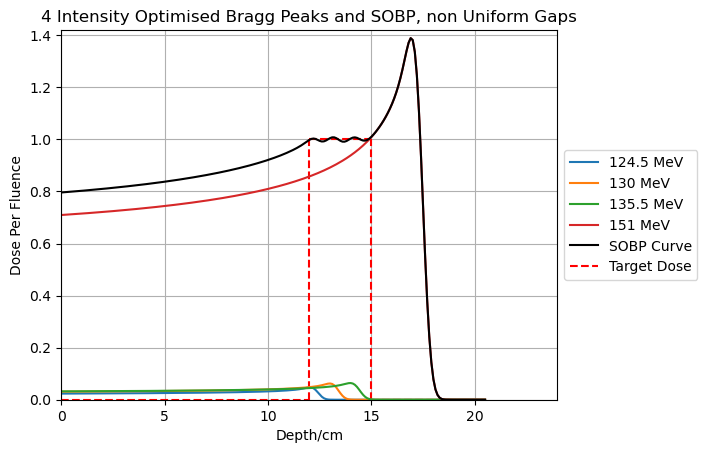

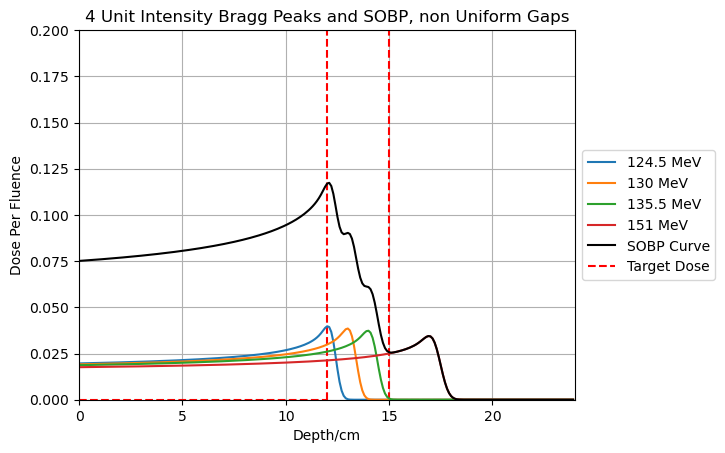

In [49]:

eVals = [124.5,130,135.5,151]
m,omega,f,d = OptimiseLAb(12,15,1,eVals)
plt.hlines(0,15,18,linestyles="dashed", color = "r")
plt.xlim([0,24])
plt.grid(True)
plt.title("4 Intensity Optimised Bragg Peaks and SOBP, non Uniform Gaps")
plt.ylim([0,1.42])
plt.xlabel("Depth/cm")
plt.ylabel("Dose Per Fluence")
plt.show()

plt.figure()
z = np.arange(0,24,0.1)
braggList = []

for i in eVals:
    plt.plot(z,Functionb(z,i), label = str(i)+ " MeV")
    braggList.append(Functionb(z,i))
    
PlotCustomBox(12,15,1)
plt.hlines(0,0,12,linestyles="dashed", color = "r")
plt.hlines(0,15,18,linestyles="dashed", color = "r")
plt.title("4 Unit Intensity Bragg Peaks and SOBP, non Uniform Gaps")
plt.legend(loc = "upper left")
plt.grid(True)
plt.plot(z,sum(braggList), color = "k", label = "SOBP Curve")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,0.2])
plt.xlim([0,24])

plt.xlabel("Depth/cm")
plt.ylabel("Dose Per Fluence")
plt.show()
